Receptor Density Maps

In [1]:
# Import all necessary libraries
#requires the python ennv neuroenv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nilearn
import nibabel as nib
import sklearn
import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import percentileofscore
#from nilearn import datasets
#from nilearn.image import resample_to_img

In [2]:
import neuromaps 
from neuromaps.datasets import fetch_atlas
from neuromaps.datasets import available_annotations
from neuromaps.datasets import available_tags
from neuromaps.datasets import fetch_annotation
from netneurotools import datasets as nntdata
from netneurotools import datasets
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps import transforms

In [23]:
mni152 = fetch_atlas('MNI152', '2mm')

In [24]:
#All possible PET annotations
for annotation in available_annotations(tags=['PET'],space='MNI152'):
    print(annotation)

('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('finnema2016', 'ucbj', 'MNI152', '1mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017', 'gsk189254', 'MNI152', '1mm')
('hesse2017', 'methylreboxetine', 'MNI152', '3mm')
('hillmer2016', 'flubatine', 'MNI152', '1mm')
('jaworska2020', 'fallypride', 'MNI152', '1mm')
('kaller2017', 'sch23390', 'MNI152', '3mm')
('kantonen2020', 'carfentanil', 'MNI152', '3mm')
('laurikainen2018', 'fmpepd2', 'MNI152', '1mm')
('naganawa2020', 

In [3]:
#load in schaefer MNI space
from nilearn.datasets import fetch_atlas_schaefer_2018
atlas_schaef_400 = fetch_atlas_schaefer_2018(n_rois=400)
print(atlas_schaef_400)


[get_dataset_dir] Dataset found in /Users/ntaylor/nilearn_data/schaefer_2018

{'maps': '/Users/ntaylor/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz', 'labels': array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4',
       b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6',
       b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
       b'7Networks_LH_Vis_9', b'7Networks_LH_Vis_10',
       b'7Networks_LH_Vis_11', b'7Networks_LH_Vis_12',
       b'7Networks_LH_Vis_13', b'7Networks_LH_Vis_14',
       b'7Networks_LH_Vis_15', b'7Networks_LH_Vis_16',
       b'7Networks_LH_Vis_17', b'7Networks_LH_Vis_18',
       b'7Networks_LH_Vis_19', b'7Networks_LH_Vis_20',
       b'7Networks_LH_Vis_21', b'7Networks_LH_Vis_22',
       b'7Networks_LH_Vis_23', b'7Networks_LH_Vis_24',
       b'7Networks_LH_Vis_25', b'7Networks_LH_Vis_26',
       b'7Networks_LH_Vis_27', b'7Networks_LH_Vis_28',
       b'7Networks_LH_Vis_29', b'7Networks_LH_Vis_30',
       b'7Networks_LH_Vis_31', b'7Networks_LH_SomMot_1',
  

Load in the pre-parcellated data from Justine Hansen - https://github.com/netneurolab/hansen_receptors/tree/main/data/PET_parcellated/scale400

https://www.nature.com/articles/s41593-022-01186-3

In [4]:
import numpy as np
from netneurotools import datasets as nntdata
#from netneurotools import plotting
from matplotlib.colors import ListedColormap
from scipy.stats import zscore
from nilearn.datasets import fetch_atlas_schaefer_2018

path = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/PhD/Code/neuromaps'

scale = 'scale400'

schaefer = fetch_atlas_schaefer_2018(n_rois=400)
nnodes = len(schaefer['labels'])

# concatenate the receptors

receptors_csv = [path+'/PET_parcellated/'+scale+'/5HT1a_way_hc36_savli.csv',
                 path+'/PET_parcellated/'+scale+'/5HT1b_p943_hc22_savli.csv',
                 path+'/PET_parcellated/'+scale+'/5HT1b_p943_hc65_gallezot.csv',
                 path+'/PET_parcellated/'+scale+'/5HT2a_cimbi_hc29_beliveau.csv',
                 path+'/PET_parcellated/'+scale+'/5HT4_sb20_hc59_beliveau.csv',
                 path+'/PET_parcellated/'+scale+'/5HT6_gsk_hc30_radhakrishnan.csv',
                 path+'/PET_parcellated/'+scale+'/5HTT_dasb_hc100_beliveau.csv',
                 path+'/PET_parcellated/'+scale+'/A4B2_flubatine_hc30_hillmer.csv',
                 path+'/PET_parcellated/'+scale+'/CB1_omar_hc77_normandin.csv',
                 path+'/PET_parcellated/'+scale+'/D1_SCH23390_hc13_kaller.csv',
                 path+'/PET_parcellated/'+scale+'/D2_flb457_hc37_smith.csv',
                 path+'/PET_parcellated/'+scale+'/D2_fallypride_hc49_jaworska.csv',
                 path+'/PET_parcellated/'+scale+'/DAT_fpcit_hc174_dukart_spect.csv',
                 path+'/PET_parcellated/'+scale+'/GABAa-bz_flumazenil_hc16_norgaard.csv',
                 path+'/PET_parcellated/'+scale+'/H3_cban_hc8_gallezot.csv', 
                 path+'/PET_parcellated/'+scale+'/M1_lsn_hc24_naganawa.csv',
                 path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc22_rosaneto.csv',
                 path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc28_dubois.csv',
                 path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc73_smart.csv',
                 path+'/PET_parcellated/'+scale+'/MU_carfentanil_hc204_kantonen.csv',
                 path+'/PET_parcellated/'+scale+'/NAT_MRB_hc77_ding.csv',
                 path+'/PET_parcellated/'+scale+'/NMDA_ge179_hc29_galovic.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc3_spreng.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc4_tuominen.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc5_bedard_sum.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc18_aghourian_sum.csv']

# combine all the receptors (including repeats)
r = np.zeros([nnodes, len(receptors_csv)])
for i in range(len(receptors_csv)):
    r[:, i] = np.genfromtxt(receptors_csv[i], delimiter=',')

receptor_names = np.array(["5HT1a", "5HT1b", "5HT2a", "5HT4", "5HT6", "5HTT", "A4B2",
                           "CB1", "D1", "D2", "DAT", "GABAa", "H3", "M1", "mGluR5",
                           "MOR", "NET", "NMDA", "VAChT"])
#np.save(path+'/receptor_names_pet.npy', receptor_names)


[get_dataset_dir] Dataset found in /Users/ntaylor/nilearn_data/schaefer_2018

In [5]:
# make final region x receptor matrix
receptor_data = np.zeros([nnodes, len(receptor_names)])
receptor_data[:, 0] = r[:, 0]
receptor_data[:, 2:9] = r[:, 3:10]
receptor_data[:, 10:14] = r[:, 12:16]
receptor_data[:, 15:18] = r[:, 19:22]

In [6]:
## receptor_data will be defined by the 19 different names of receptor_names
# weighted average of 5HT1B p943
receptor_data[:, 1] = (zscore(r[:, 1])*22 + zscore(r[:, 2])*65) / (22+65)

# weighted average of D2 flb457
receptor_data[:, 9] = (zscore(r[:, 10])*37 + zscore(r[:, 11])*55) / (37+55)

# weighted average of mGluR5 ABP688
receptor_data[:, 14] = (zscore(r[:, 16])*22 + zscore(r[:, 17])*28 + zscore(r[:, 18])*73) / (22+28+73)

# weighted average of VAChT FEOBV
receptor_data[:, 18] = (zscore(r[:, 22])*3 + zscore(r[:, 23])*4 + zscore(r[:, 24])+ zscore(r[:, 25])) / \
                       (3+4+5+18)

Plot of the receptors onto the schaefer cortex

In [29]:
# Plot receptor Data onto brain
from netneurotools.plotting import plot_fsaverage
from netneurotools.datasets import fetch_schaefer2018
import numpy as np
from matplotlib.colors import ListedColormap

In [30]:
pip show pysurfer

Name: pysurfer
Version: 0.11.2
Summary: PySurfer: cortical surface visualization using Python.
Home-page: http://pysurfer.github.com
Author: 
Author-email: 
License: BSD (3-clause)
Location: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages
Requires: matplotlib, mayavi, nibabel, numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


Look at Receptor Distributions vs Regions that are significantly different in PC values

In [3]:
#load in the avg PC for each grp

#directory of load in data
path ='/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400'

#load in the avg PC for each grp
avg_pc_del = np.genfromtxt(path + '/avg_pc_del.csv', delimiter=',')
avg_pc_nondel = np.genfromtxt(path + '/avg_pc_nondel.csv', delimiter=',')
sig_avg_pc = np.genfromtxt(path + '/significant_rois_avg_pc.csv', delimiter=',')
#create only pc values for the 400 schaef regions
avg_pc_del_400 = avg_pc_del[:,0:400]
avg_pc_nondel_400 = avg_pc_nondel[:,0:400]

In [4]:
mean_pc_del = np.mean(avg_pc_del_400, axis=0)
mean_pc_nondel = np.mean(avg_pc_nondel_400, axis=0)

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the correlation between avg_pc_del and receptor_data
correlations = np.corrcoef(receptor_data.T, mean_pc_del.T)
#correlations = np.corrcoef(receptor_data.T, avg_pc_del_400.T)
# Extract the relevant part of the correlation matrix
correlations = correlations[:-1, -1]

# Create a DataFrame for easier plotting
correlation_df = pd.DataFrame(correlations, index=receptor_names, columns=['Correlation'])

# Plot the linear relationship for each receptor
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.T, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Avg. PC Delirium and Receptor Data')
plt.show()

# Plot the linear relationship for each receptor
for i in range(len(receptor_names)):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=mean_pc_del.flatten(), y=receptor_data[:, i])
    plt.xlabel('avg_pc_del')
    plt.ylabel(receptor_names[i])  # Access receptor name using indexing
    plt.title(f'Linear Relationship between avg_pc_del and {receptor_names[i]}')
    plt.show()

In [68]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming receptor_data, avg_pc_del, avg_pc_nondel, and receptor_names are already loaded

# Calculate the correlation between avg_pc_del and receptor_data
[correlations_del,pvalue_del]=stats.permtest_pearsonr(receptor_data,mean_pc_del, n_perm=1000)

# Calculate the correlation between avg_pc_nondel and receptor_data
[correlations_nondel,pvalue_nondel]=stats.permtest_pearsonr(receptor_data,mean_pc_nondel, n_perm=1000)

# Create DataFrames for easier plotting
# Create DataFrames for easier plotting
correlation_df_del = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_del,
    'P-Value Permuted': pvalue_del
})

correlation_df_nondel = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_nondel,
    'P-Value Permuted': pvalue_nondel
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_del = correlation_df_del[correlation_df_del['P-Value Permuted'] < significance_threshold]
significant_results_nondel = correlation_df_nondel[correlation_df_nondel['P-Value Permuted'] < significance_threshold]

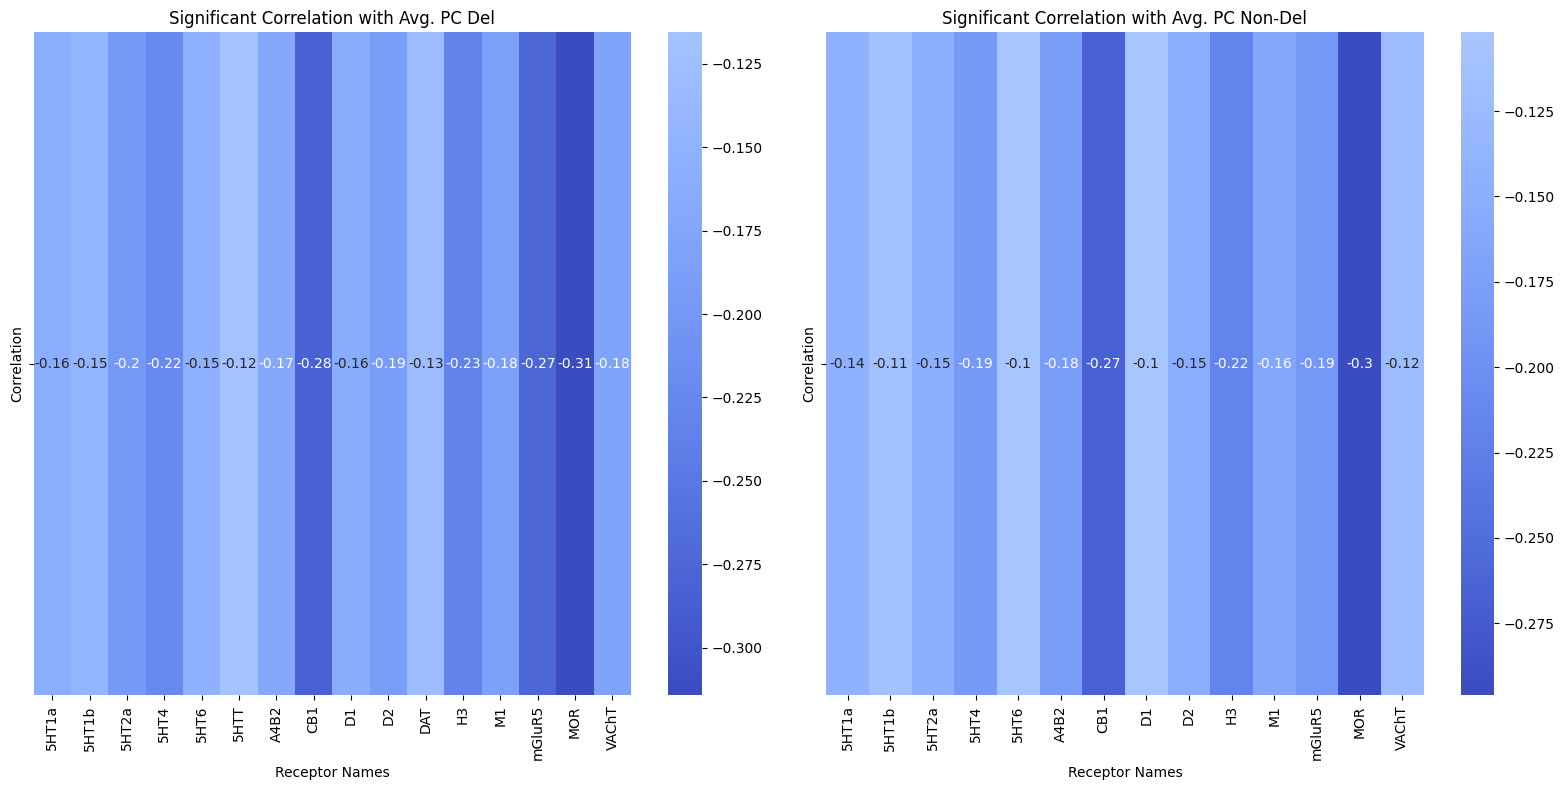

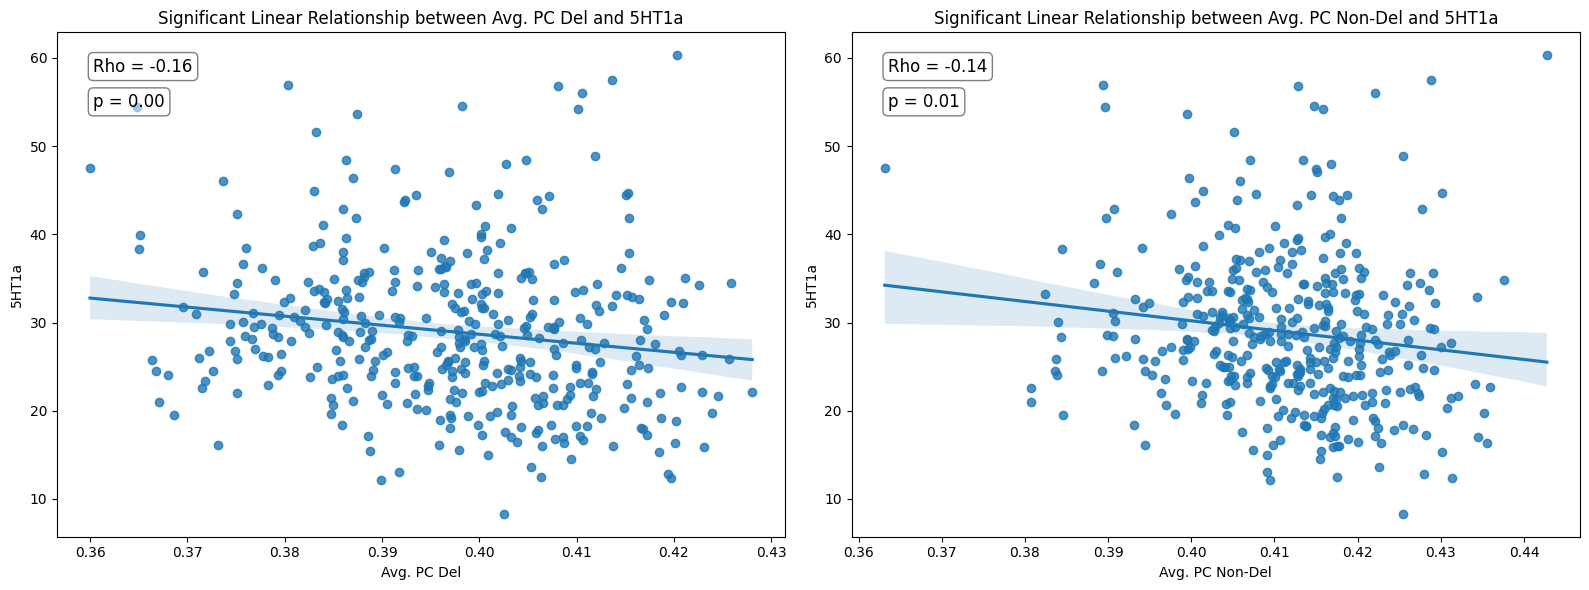

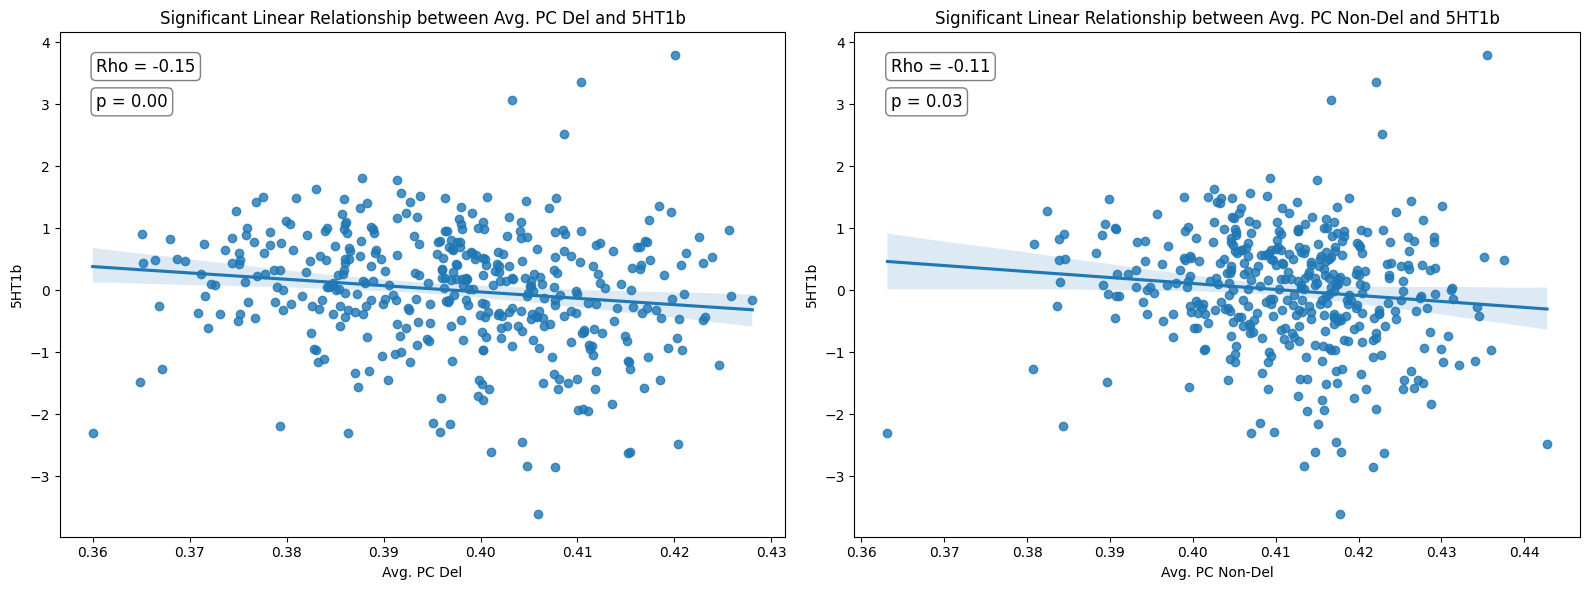

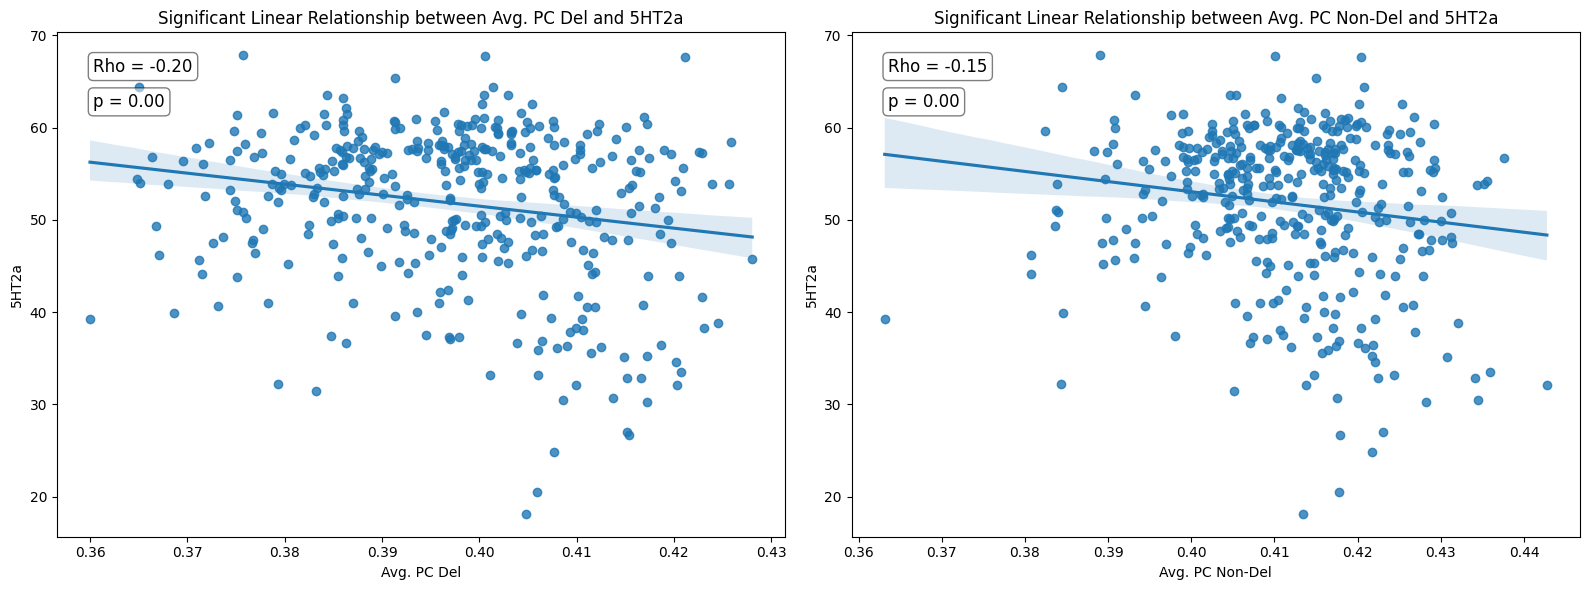

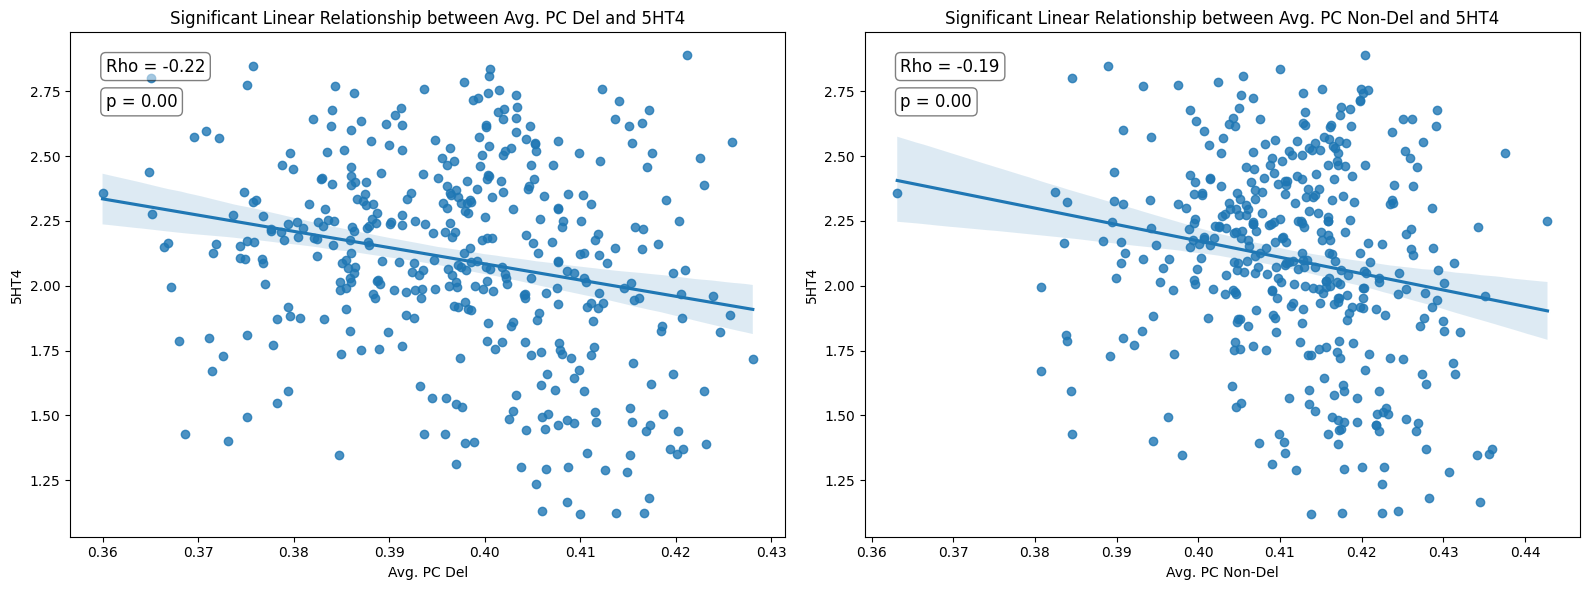

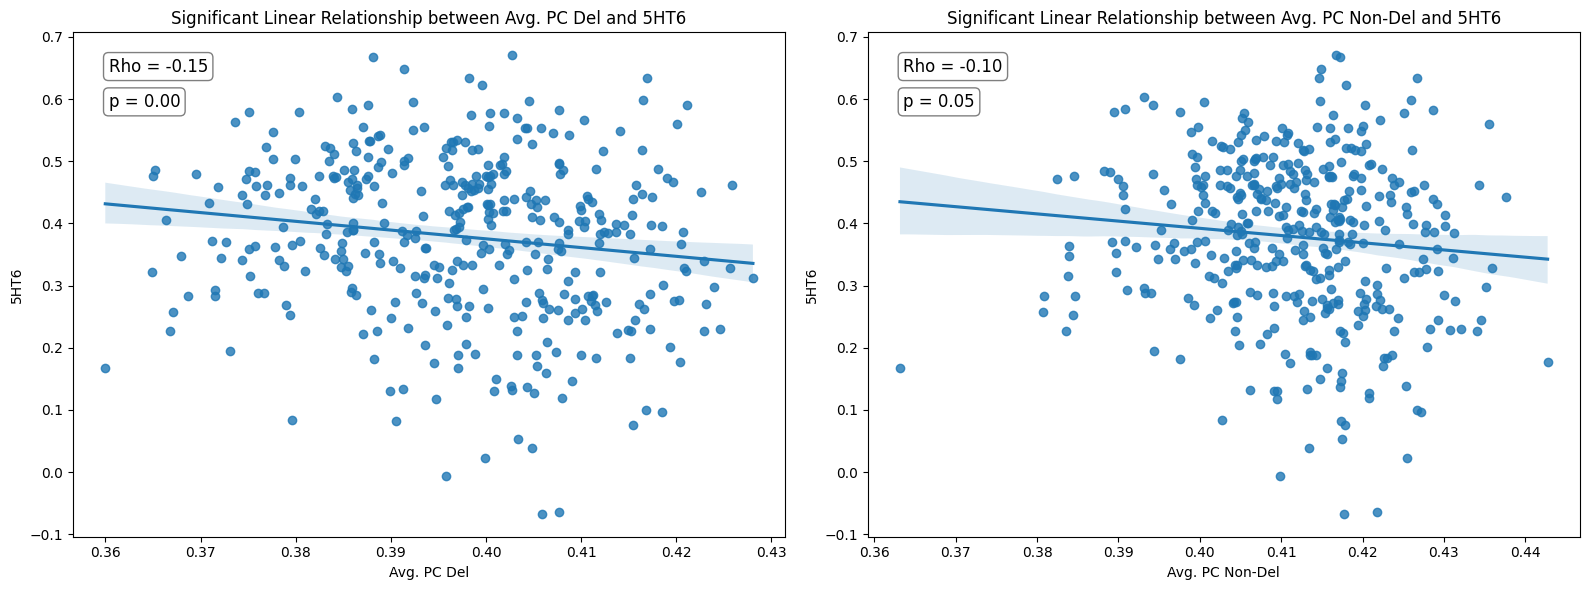

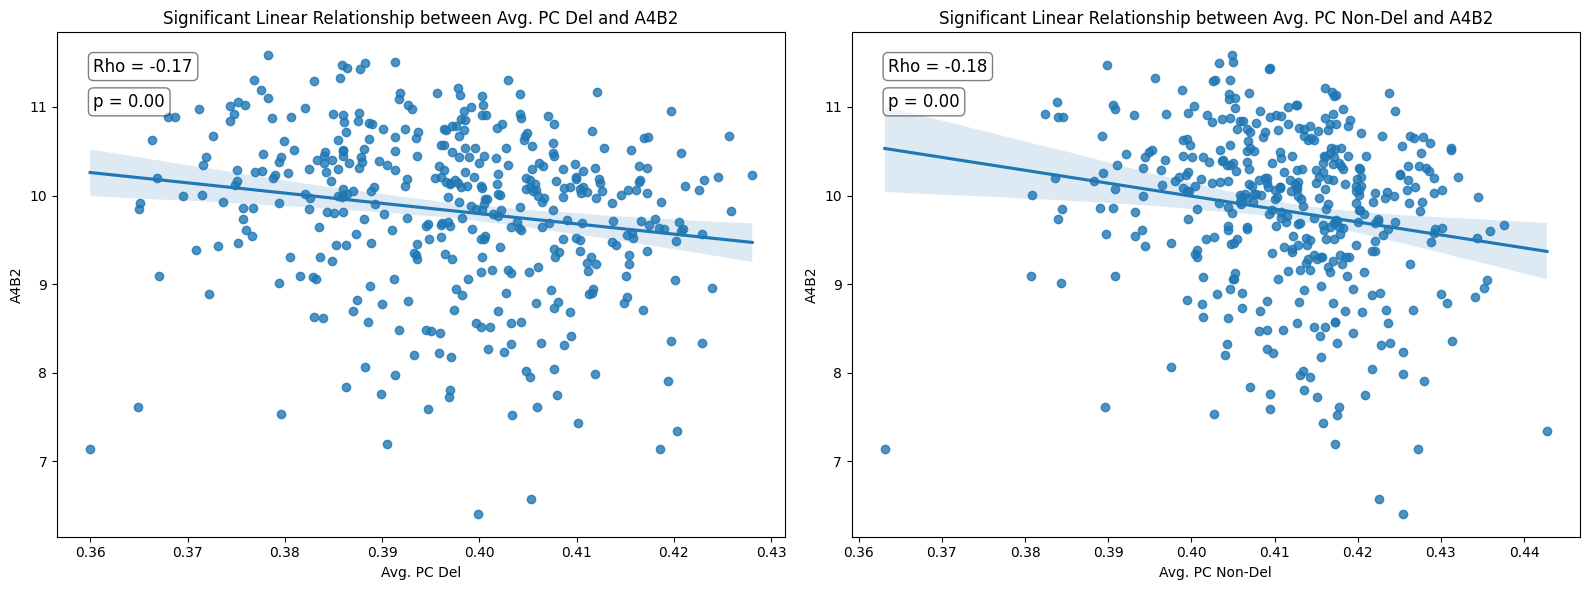

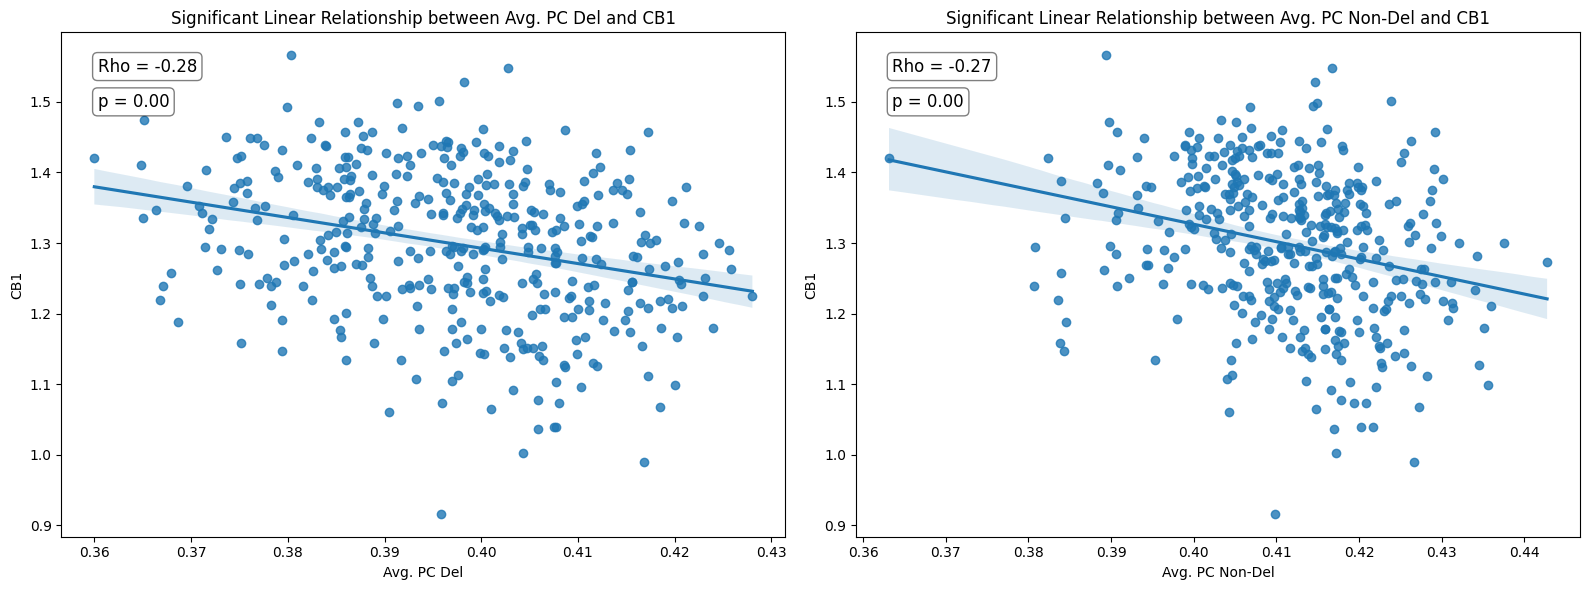

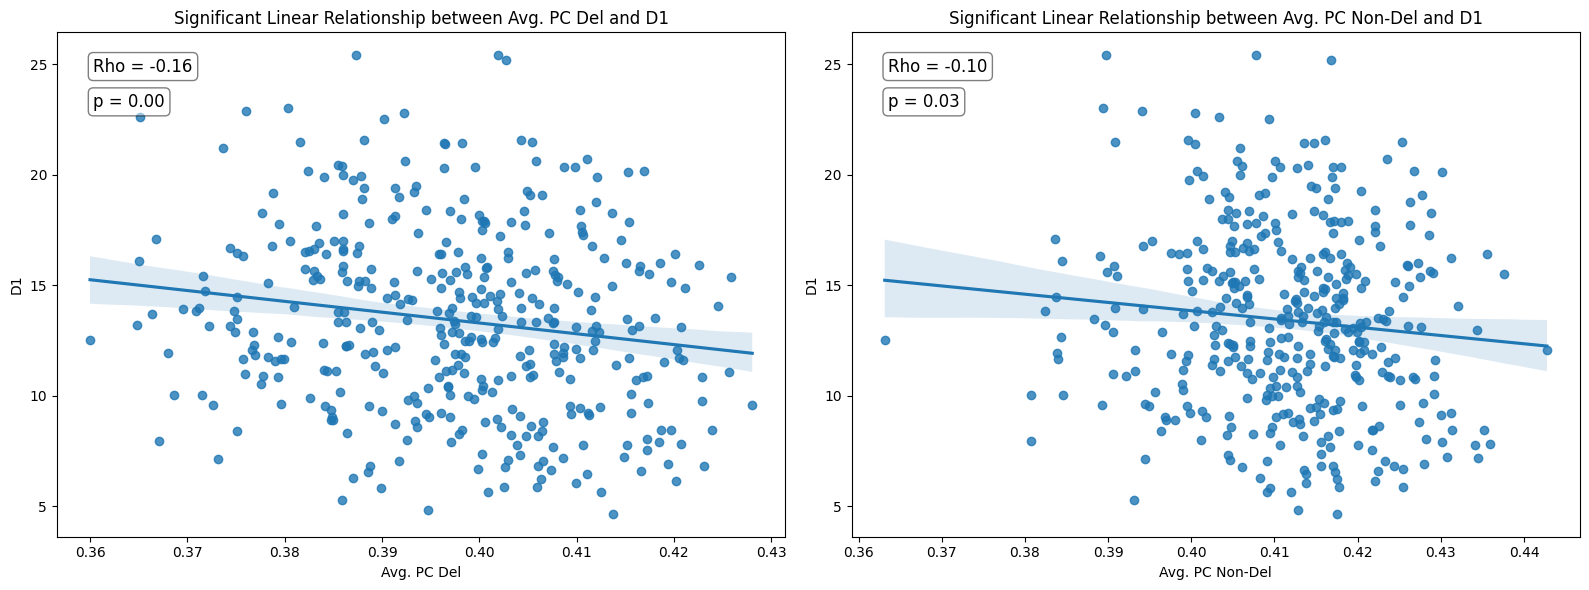

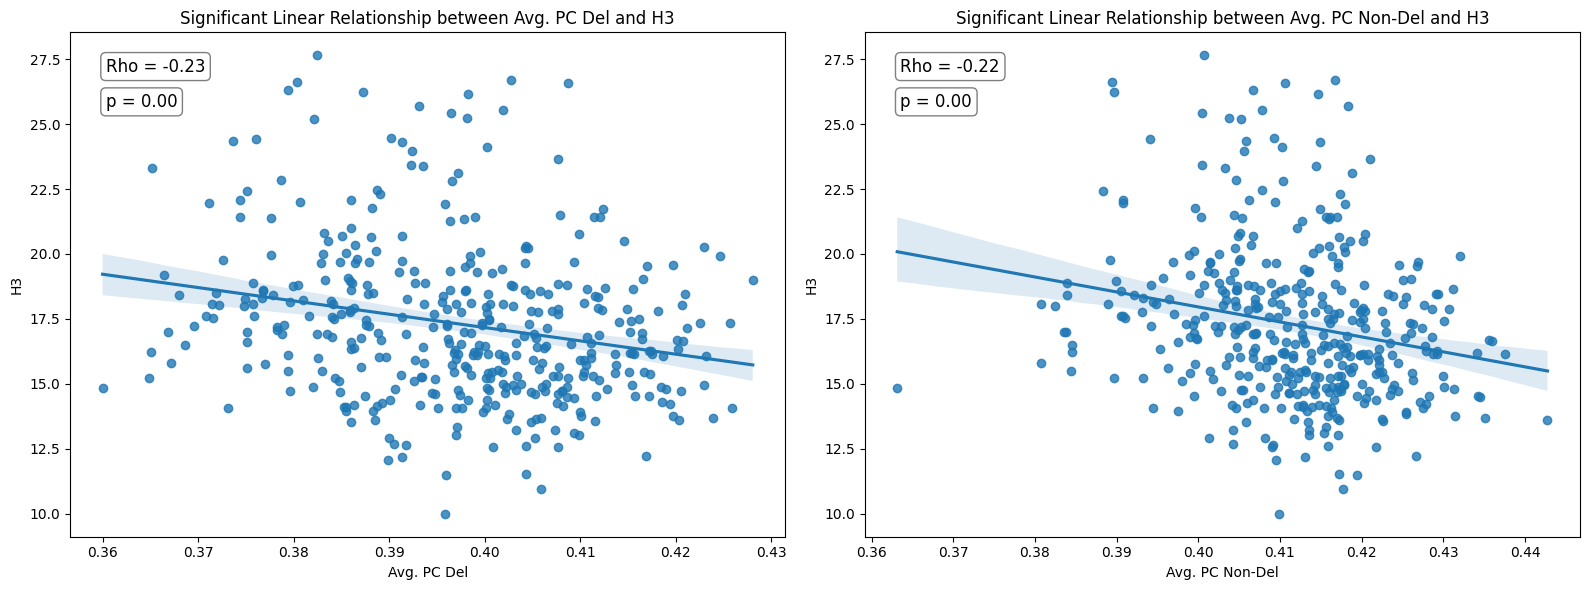

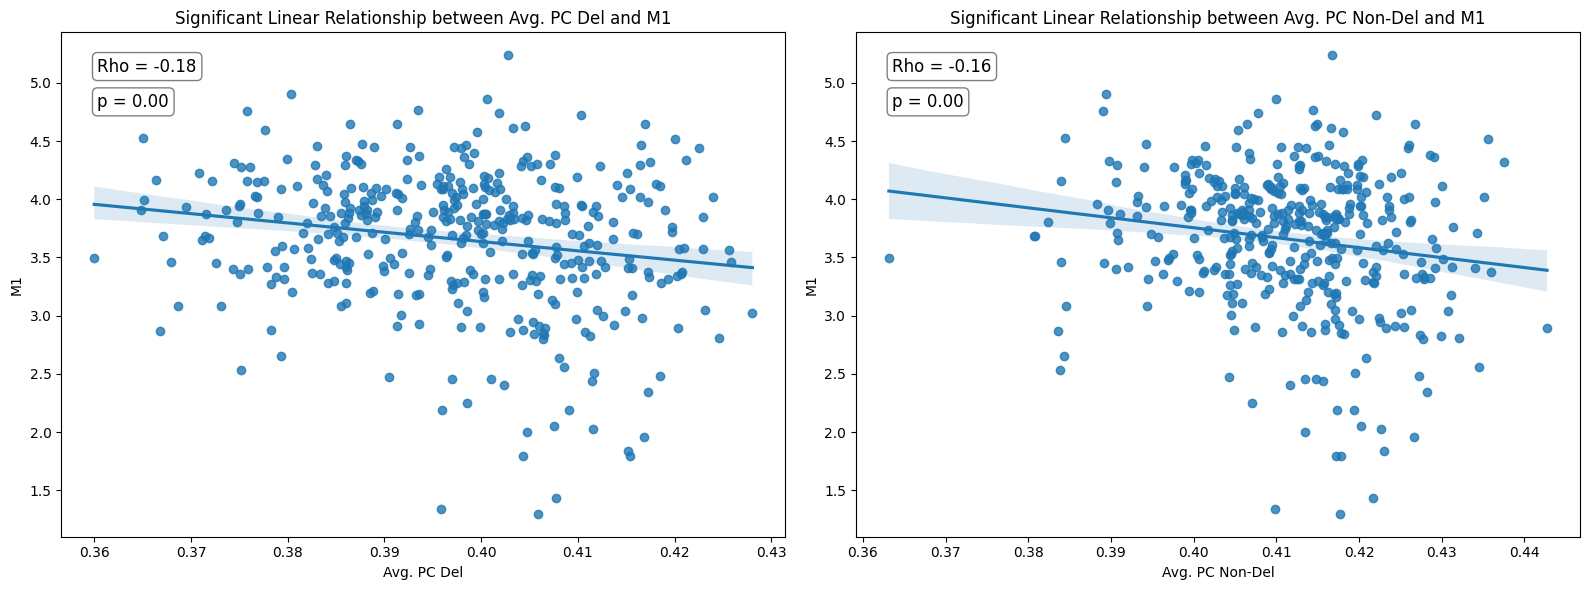

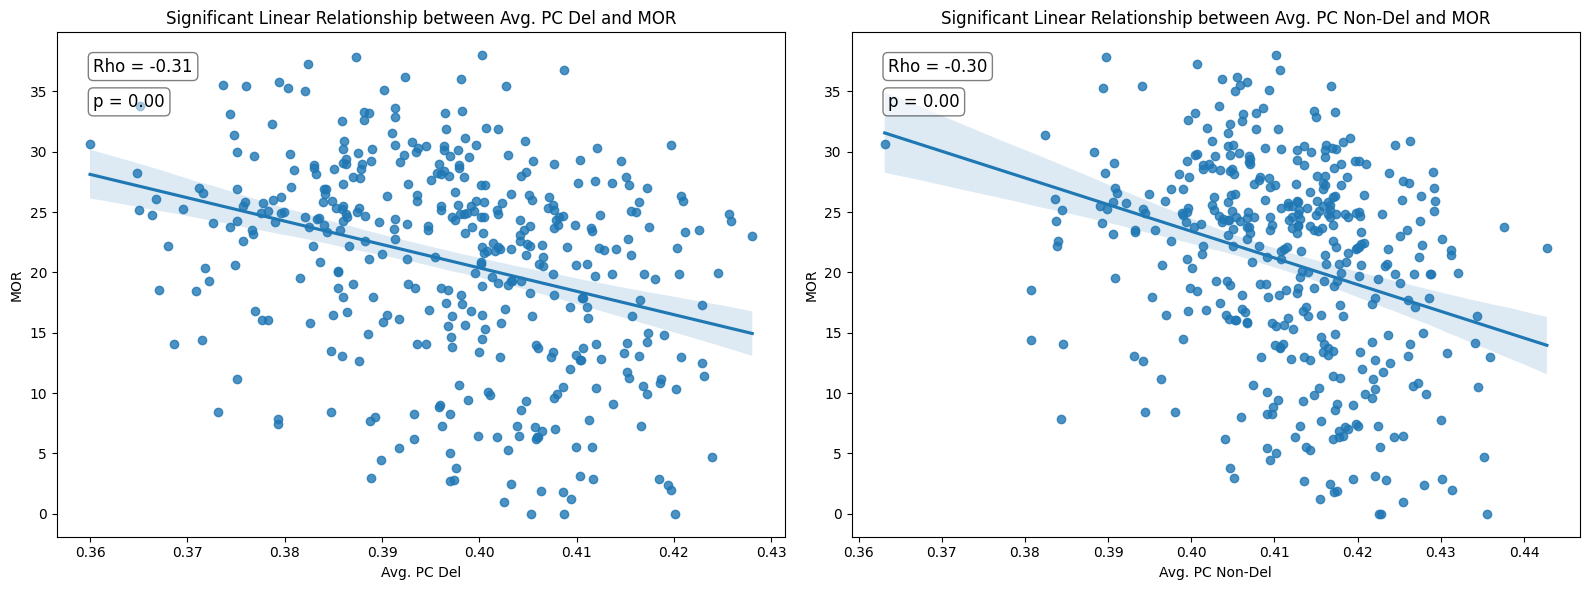

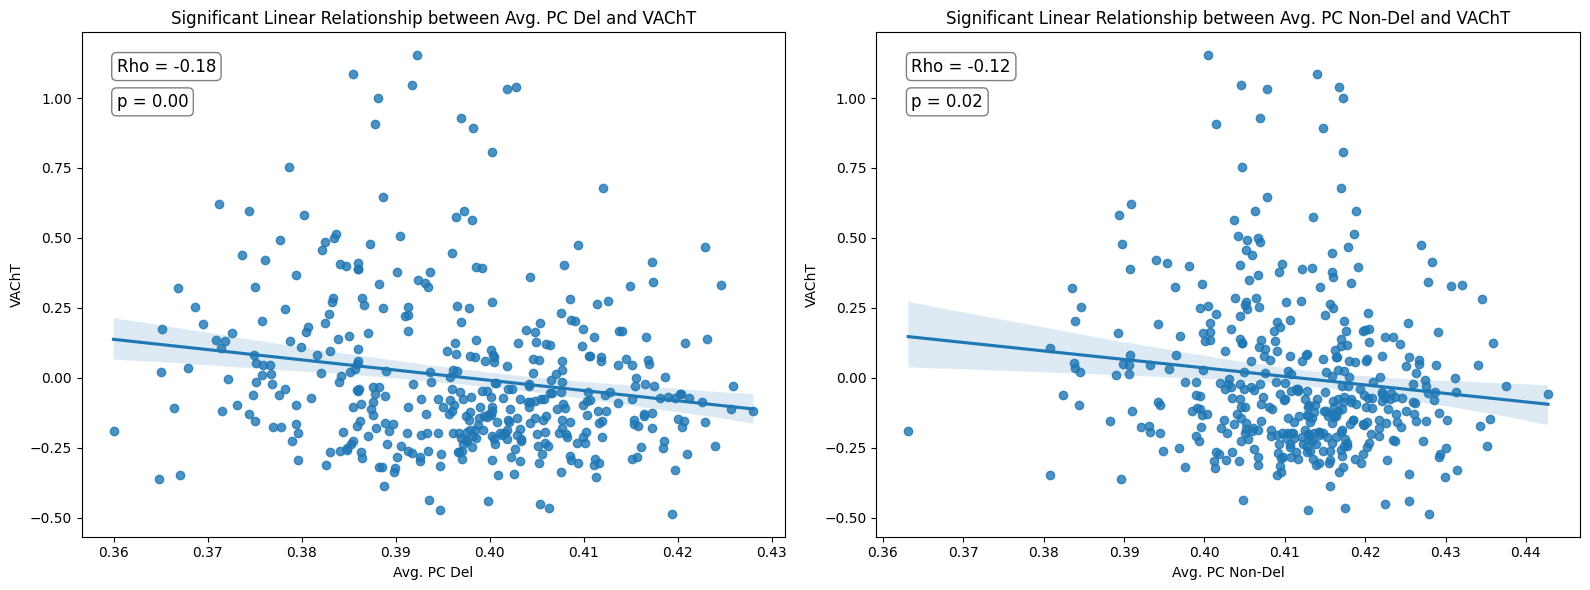

In [71]:
# Ensure significant_results_del and significant_results_nondel contain numeric data for plotting
if 'Correlation' in significant_results_del.columns and 'Correlation' in significant_results_nondel.columns:
    correlation_values_del = significant_results_del[['Correlation']].astype(float)
    correlation_values_nondel = significant_results_nondel[['Correlation']].astype(float)
else:
    raise ValueError("One of the significant_results DataFrames does not contain a 'Correlation' column.")

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for significant_results_del
sns.heatmap(correlation_values_del.T, annot=True, cmap='coolwarm', center=0, 
            xticklabels=significant_results_del['Receptor'], ax=axes[0])
axes[0].set_title('Significant Correlation with Avg. PC Del')
axes[0].set_xlabel('Receptor Names')

# Heatmap for significant_results_nondel
sns.heatmap(correlation_values_nondel.T, annot=True, cmap='coolwarm', center=0, 
            xticklabels=significant_results_nondel['Receptor'], ax=axes[1])
axes[1].set_title('Significant Correlation with Avg. PC Non-Del')
axes[1].set_xlabel('Receptor Names')

plt.tight_layout()
plt.show()

# Iterate over significant receptors for both del and nondel
for receptor in significant_results_nondel['Receptor']:
    i = np.where(receptor_names == receptor)[0][0]  # Find the corresponding index in receptor_names
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot for Avg. PC Del
    sns.regplot(x=mean_pc_del.flatten(), y=receptor_data[:, i], ax=axes[0])
    axes[0].set_xlabel('Avg. PC Del')
    axes[0].set_ylabel(receptor)
    axes[0].set_title(f'Significant Linear Relationship between Avg. PC Del and {receptor}')
    
    # Calculate correlation for Avg. PC Del
    rho_del = np.corrcoef(mean_pc_del.flatten(), receptor_data[:, i])[0, 1]
    pval_del = significant_results_del[significant_results_del['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Del
    axes[0].text(0.05, 0.95, f'Rho = {rho_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[0].text(0.05, 0.88, f'p = {pval_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Plot for Avg. PC Non-Del
    sns.regplot(x=mean_pc_nondel.flatten(), y=receptor_data[:, i], ax=axes[1])
    axes[1].set_xlabel('Avg. PC Non-Del')
    axes[1].set_ylabel(receptor)
    axes[1].set_title(f'Significant Linear Relationship between Avg. PC Non-Del and {receptor}')
    
    # Calculate correlation for Avg. PC Non-Del
    rho_nondel = np.corrcoef(mean_pc_nondel.flatten(), receptor_data[:, i])[0, 1]
    pval_nondel = significant_results_nondel[significant_results_nondel['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Non-Del
    axes[1].text(0.05, 0.95, f'Rho = {rho_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[1].text(0.05, 0.88, f'p = {pval_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

In [11]:
# diff between del and non del
diff_mean_pc_400 = mean_pc_del - mean_pc_nondel

In [12]:
# spin permutation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from netneurotools import stats

# Calculate the observed correlation
#observed_correlations = [pearsonr(analyse_data, receptor_data[:, i])[0] for i in range(receptor_data.shape[1])]

analyse_data = diff_mean_pc_400
[corr,pvalue]=stats.permtest_pearsonr(analyse_data,receptor_data, n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted[correlation_permuted['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(correlation_permuted)

   Receptor  Correlation  P-Value Permuted
0     5HT1a    -0.075689          0.131868
1     5HT1b    -0.089936          0.072927
2     5HT2a    -0.126387          0.012987
3      5HT4    -0.120370          0.013986
4      5HT6    -0.113315          0.018981
5      5HTT    -0.111671          0.026973
6      A4B2    -0.042136          0.402597
7       CB1    -0.110542          0.025974
8        D1    -0.134002          0.007992
9        D2    -0.113527          0.029970
10      DAT    -0.128427          0.008991
11    GABAa    -0.135364          0.003996
12       H3    -0.094719          0.057942
13       M1    -0.086224          0.076923
14   mGluR5    -0.205040          0.000999
15      MOR    -0.120595          0.015984
16      NET    -0.024328          0.633367
17     NMDA    -0.089612          0.074925
18    VAChT    -0.134647          0.006993


Spin Permutation Test - for significance

In [13]:
# spin permutation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from netneurotools import stats

# Calculate the observed correlation
#observed_correlations = [pearsonr(analyse_data, receptor_data[:, i])[0] for i in range(receptor_data.shape[1])]

analyse_data = diff_mean_pc_400
[corr,pvalue]=stats.permtest_pearsonr(analyse_data,receptor_data, n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted[correlation_permuted['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(correlation_permuted)
#print(significant_results)

   Receptor  Correlation  P-Value Permuted
0     5HT1a    -0.075689          0.131868
1     5HT1b    -0.089936          0.072927
2     5HT2a    -0.126387          0.012987
3      5HT4    -0.120370          0.013986
4      5HT6    -0.113315          0.018981
5      5HTT    -0.111671          0.026973
6      A4B2    -0.042136          0.402597
7       CB1    -0.110542          0.025974
8        D1    -0.134002          0.007992
9        D2    -0.113527          0.029970
10      DAT    -0.128427          0.008991
11    GABAa    -0.135364          0.003996
12       H3    -0.094719          0.057942
13       M1    -0.086224          0.076923
14   mGluR5    -0.205040          0.000999
15      MOR    -0.120595          0.015984
16      NET    -0.024328          0.633367
17     NMDA    -0.089612          0.074925
18    VAChT    -0.134647          0.006993


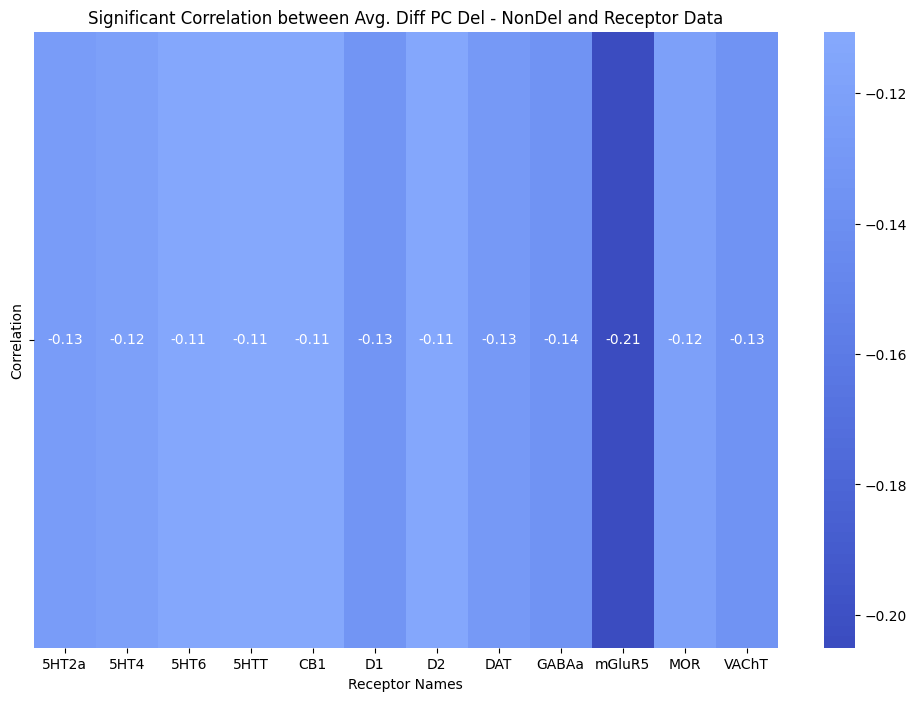

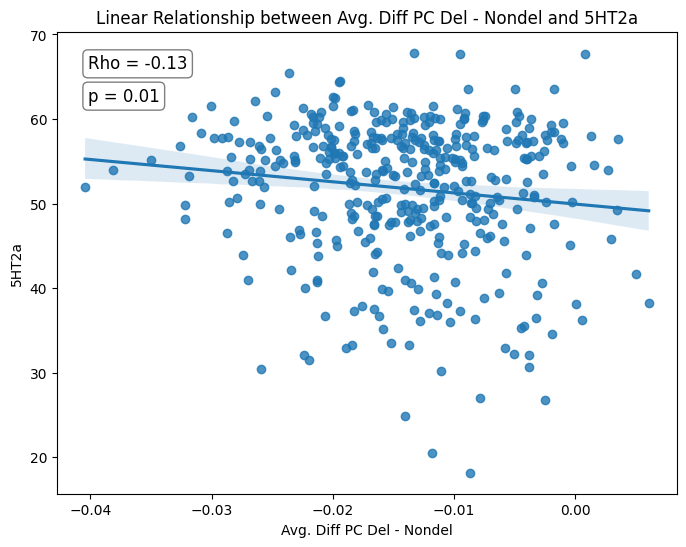

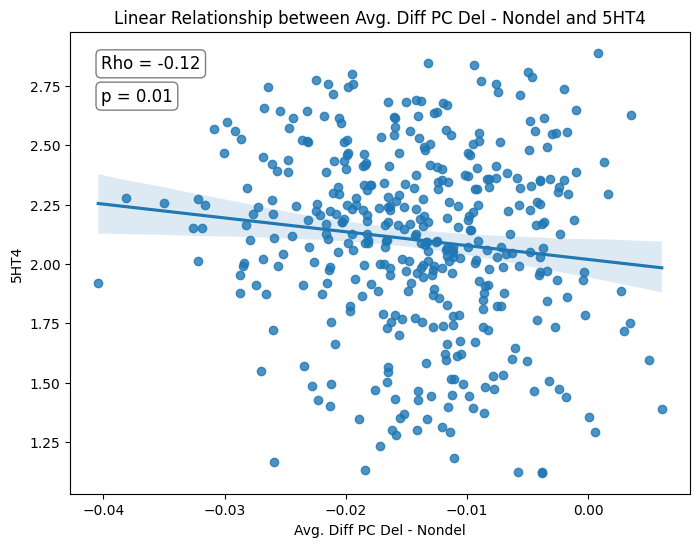

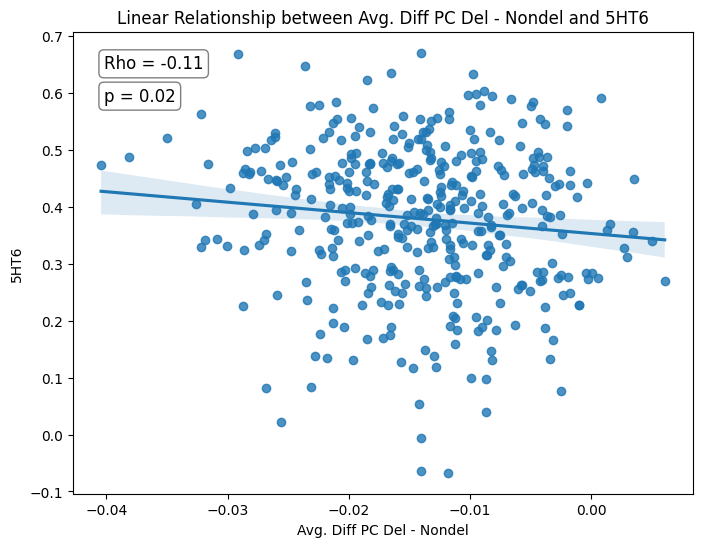

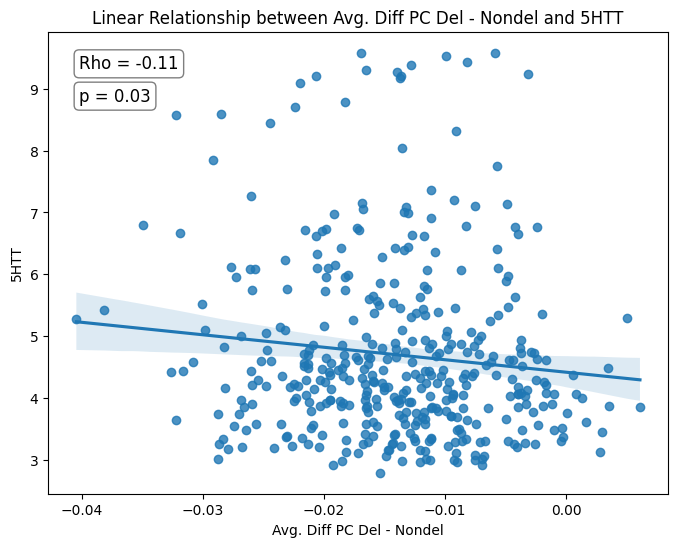

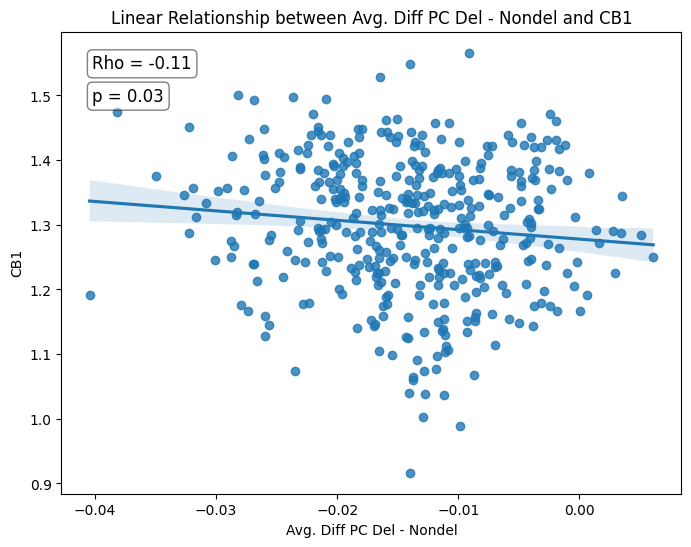

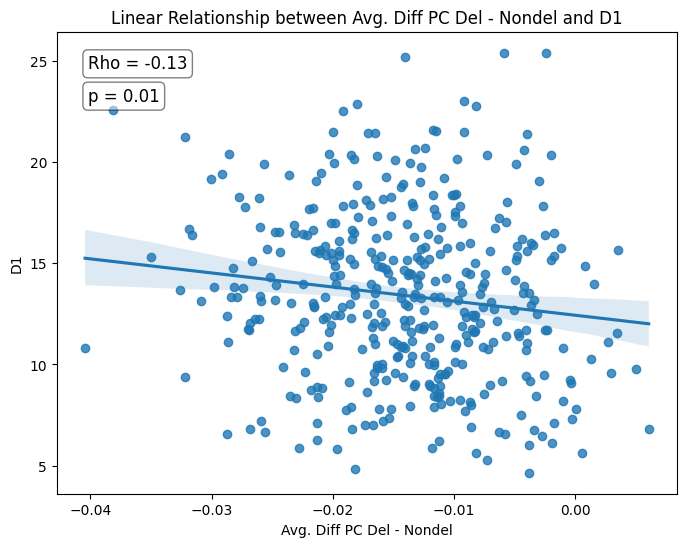

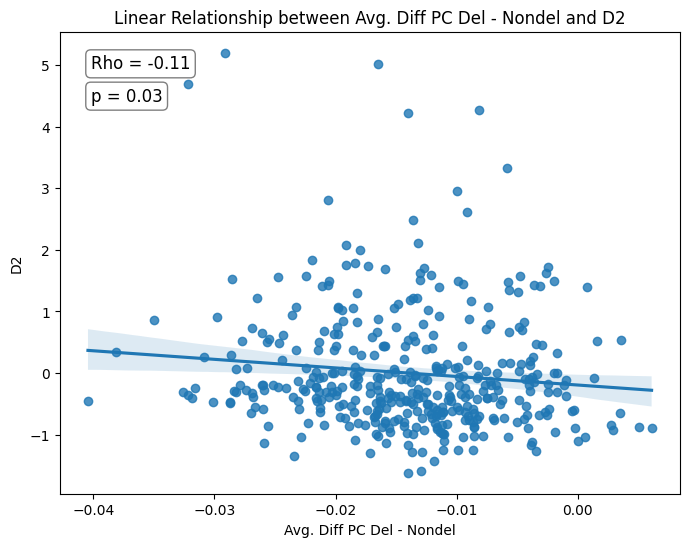

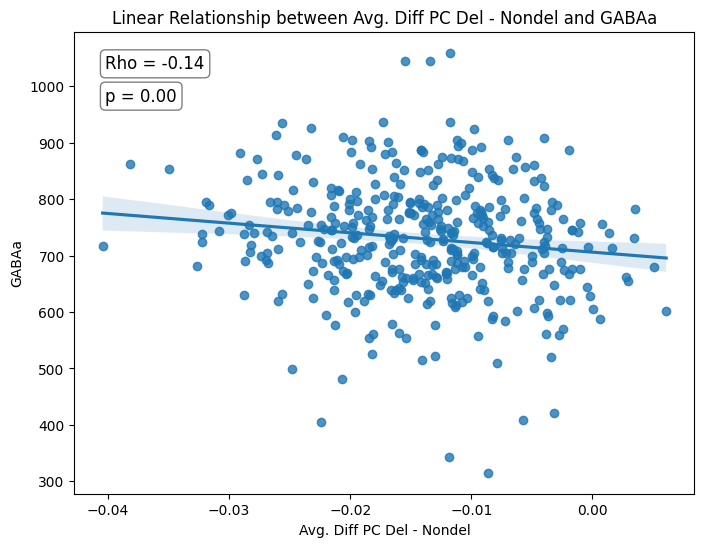

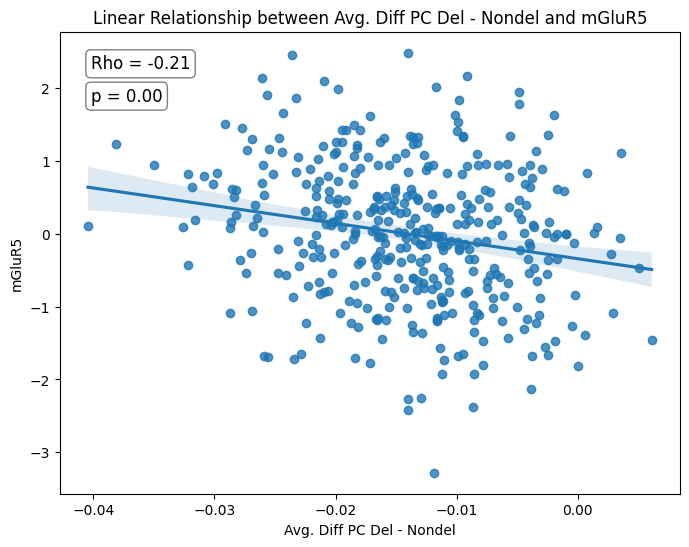

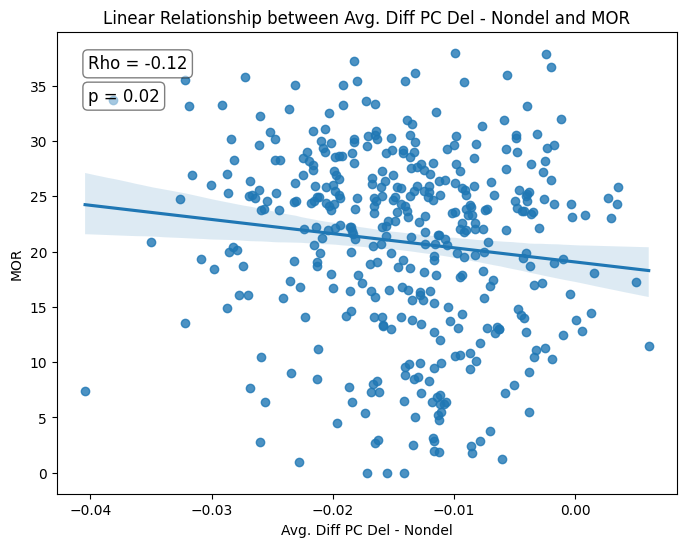

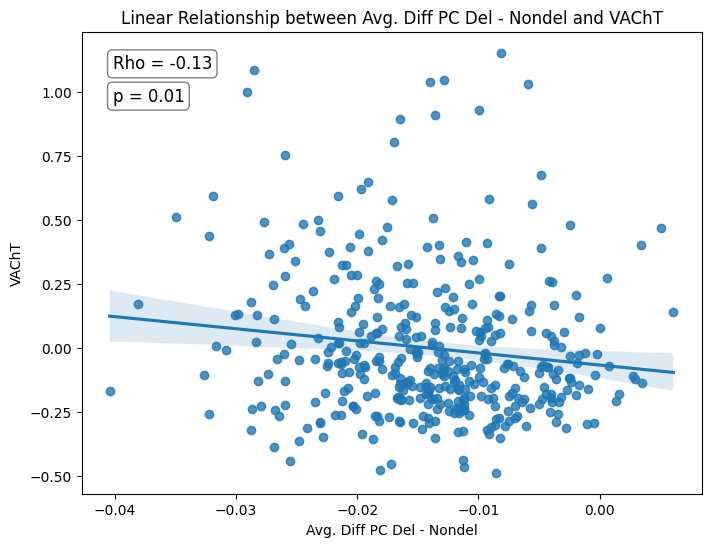

In [74]:
# Ensure significant_results contains numeric data for plotting
if 'Correlation' in significant_results.columns:
    correlation_values = significant_results[['Correlation']].astype(float)
else:
    raise ValueError("significant_results does not contain a 'Correlation' column.")

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_values.T, annot=True, cmap='coolwarm', center=0, xticklabels=significant_results['Receptor'])
plt.title('Significant Correlation between Avg. Diff PC Del - NonDel and Receptor Data')
plt.xlabel('Receptor Names')  # Add x-axis label
plt.show()

# Iterate over significant receptors
for receptor in significant_results.Receptor:  # Use the index of significant_results (receptor names)
    i = np.where(receptor_names == receptor)[0][0]  # Find the corresponding index in receptor_names
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x=diff_mean_pc_400.flatten(), y=receptor_data[:, i])
    plt.xlabel('Avg. Diff PC Del - Nondel')
    plt.ylabel(receptor)
    plt.title(f'Linear Relationship between Avg. Diff PC Del - Nondel and {receptor}')
    
    # Calculate correlation
    rho = np.corrcoef(diff_mean_pc_400.flatten(), receptor_data[:, i])[0, 1]
    pval = significant_results[significant_results['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    plt.text(0.05, 0.95, f'Rho = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.88, f'p = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.show()

## Look at the relationship when we loop through each region (across subjects)




In [ ]:
#select data
analyse_data = avg_pc_del_400
subjects = analyse_data.shape[0]  # select subjects based on rows length

selected_receptors = ['NET','VAChT', 'M1','A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]

# Perform permutation test for each subject
for s in range(subjects):
    corr, pvalue = stats.permtest_pearsonr(analyse_data[s, :], receptor_data[:, selected_indices], n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted_ROIs = pd.DataFrame({
    'Receptor': selected_receptors,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted_ROIs[correlation_permuted_ROIs['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(significant_results)

# Iterate over significant receptors


  Receptor  Correlation  P-Value Permuted
1    VAChT    -0.139433          0.007992
2       M1    -0.134782          0.005994


Plot the receptor distributions for specific regions - 
- see whether there are differences in receptor distribution for specific regions that are significantly different in PC for delirium vs non-del

In [5]:
#load in fc for the brain regions
path = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400'

sig_pc_overtime_diff = np.genfromtxt(path + '/mean_diff_del_health_pc_avg_time.csv', delimiter=',')

selected_receptors = ['NET','VAChT', 'M1','A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]


analyse_data = diff_mean_pc_400
[corr,pvalue]=stats.permtest_pearsonr(analyse_data,receptor_data[:,selected_indices], n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted = pd.DataFrame({
    'Receptor': selected_receptors,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted[correlation_permuted['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(correlation_permuted)


# Plot the linear relationship for each significant receptor in selected_indices
for receptor in significant_results['Receptor']:
    i = np.where(receptor_names == receptor)[0][0]
    plt.figure(figsize=(8, 6))
    sns.regplot(x=diff_mean_pc_400.flatten(), y=receptor_data[:, i])
    plt.xlabel('Avg. Diff PC Del - Nondel')
    plt.ylabel(receptor)
    plt.title(f'Linear Relationship between Avg. Diff PC Del - Nondel and {receptor}')
    # Calculate correlation and p-value
    rho = significant_results[significant_results['Receptor'] == receptor]['Correlation'].values[0]
    pval = significant_results[significant_results['Receptor'] == receptor]['P-Value Permuted'].values[0]
    plt.text(0.05, 0.95, f'Rho = {rho:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.88, f'p = {pval:.3f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()


NameError: name 'receptor_names' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, datasets, surface
from nilearn.surface import vol_to_surf

# Load the Schaefer 400 atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=1, yeo_networks=7)
atlas_filename = schaefer_atlas['maps']
labels = schaefer_atlas['labels']

# Create a DataFrame for receptor data
receptor_df = pd.DataFrame(receptor_data, columns=receptor_names)

# Load the fsaverage surface mesh
fsaverage = datasets.fetch_surf_fsaverage()

# Plot the receptor data onto the Schaefer 400 atlas
for receptor in receptor_names:
    # Sample the receptor data to the surface
    texture = vol_to_surf(atlas_filename, fsaverage.pial_left)
    
    # Create a 3D plot for each receptor
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 8))
    plotting.plot_surf_stat_map(
        fsaverage.pial_left,
        stat_map=texture,
        hemi='left',
        view='lateral',
        colorbar=True,
        title=f'{receptor} Distribution on Schaefer 400 Atlas',
        axes=ax
    )
    plt.show()

In [ ]:
receptor_interest = ['VAChT', 'M1']  # Assuming these are the names of the receptors

# Load the Schaefer 400 atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=1, yeo_networks=7)
atlas_filename = schaefer_atlas['maps']
labels = schaefer_atlas['labels']

# Filter receptor data based on receptor_interest
receptor_df = pd.DataFrame(receptor_data, columns=receptor_names)
receptor_df = receptor_df[receptor_interest]

# Project receptor data onto the surface mesh
fsaverage = datasets.fetch_surf_fsaverage()
for receptor in receptor_interest:
    # Sample the receptor data to the surface
    texture = vol_to_surf(atlas_filename, fsaverage.pial_left)
    
    # Create a 3D plot for each receptor
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 8))
    plotting.plot_surf_stat_map(
        fsaverage.pial_left,
        stat_map=texture,
        hemi='left',
        view='lateral',
        colorbar=True,
        title=f'{receptor} Distribution on Schaefer 400 Atlas',
        axes=ax
    )
    plt.show()

In [ ]:
# just significantly different in PC between del and non del for receptor data
sig_pc_receptors_roi = sig_avg_pc[0:400, np.newaxis] * receptor_data

In [ ]:
receptor_df = pd.DataFrame(receptor_data, columns=receptor_names)

In [76]:
# Load the Schaefer 400 atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2, yeo_networks=17)

#annot = fetch_schaefer2018('fsaverage', verbose=False)['400Parcels17Networks']
nnodes = len(schaefer['labels'])
#coords = np.genfromtxt(path+'data/schaefer/figures/scahefer400/Schaefer_400_centres.txt')[:, 1:]
atlas_filename = schaefer_atlas['maps']
labels = schaefer_atlas['labels']

# Plot the VAChT receptor data onto the Schaefer 400 atlas
receptor = 'VAChT'
texture = vol_to_surf(schaefer_atlas, fsaverage.pial_left)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(10, 8))
plotting.plot_surf_stat_map(
    fsaverage.pial_left,
    stat_map=texture,
    hemi='left',
    view='lateral',
    colorbar=True,
    title=f'{receptor} Distribution on Schaefer 400 Atlas',
    axes=ax
)
plt.show()

AttributeError: module 'netneurotools.datasets' has no attribute 'fetch_atlas_schaefer_2018'

## Relationship between gradient of FC (across the cortex scahefer 400) to AAS Nuclei

In [6]:
#load in the avg PC for each grp

#directory of load in data - AAS Functional Connectivity
path ='/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Functional_Connectivity/AAS_nuclei'

#load in the avg PC for each grp
avg_fc_lc_all = np.genfromtxt(path + '/avg_LC_fc_400_all_subs.csv', delimiter=',')
avg_fc_nbm_all = np.genfromtxt(path + '/avg_nbm_fc_400_all_subs.csv', delimiter=',')
avg_fc_ppn_all = np.genfromtxt(path + '/avg_ppn_fc_400_all_subs.csv', delimiter=',')
#create regions significantly different based on permutation test
sig_fc_nuclei = np.genfromtxt(path + '/sig_fc_lc_nbm_ppn.csv', delimiter=',') #LC, NBM, PPN

In [8]:
import numpy as np

# load in clinical data
subject_data = np.genfromtxt("/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Demographic_Data/subject_data_IL810_mri.csv", delimiter=',', names=True, dtype=None, encoding='utf-8')

# Filter data for subjects with delirium
delirium_indices = np.where(subject_data['bin_delirium'] == 1)[0]
non_delirium_indices = np.where(subject_data['bin_delirium'] == 0)[0]

In [104]:
print(avg_fc_lc_all.shape)

(120, 400)


In [9]:
# sort avg fc into the delirium and non-delirium grps
avg_fc_lc_del = avg_fc_lc_all[delirium_indices, :]
avg_fc_lc_nondel = avg_fc_lc_all[non_delirium_indices, :]

avg_fc_nbm_del = avg_fc_nbm_all[delirium_indices, :]
avg_fc_nbm_nondel = avg_fc_nbm_all[non_delirium_indices, :]

avg_fc_ppn_del = avg_fc_ppn_all[delirium_indices, :]
avg_fc_ppn_nondel = avg_fc_ppn_all[non_delirium_indices, :]

In [106]:
print(avg_fc_lc_del.shape)

(31, 400)


In [172]:
#reshape avg_fc_lc_del to 400 schaef regions as rows and subjects as columns
avg_fc_lc_del_400 = avg_fc_lc_del.T
print(avg_fc_lc_del_400.shape)

aa = receptor_data.T
print(aa.shape)

(400, 31)
(19, 400)


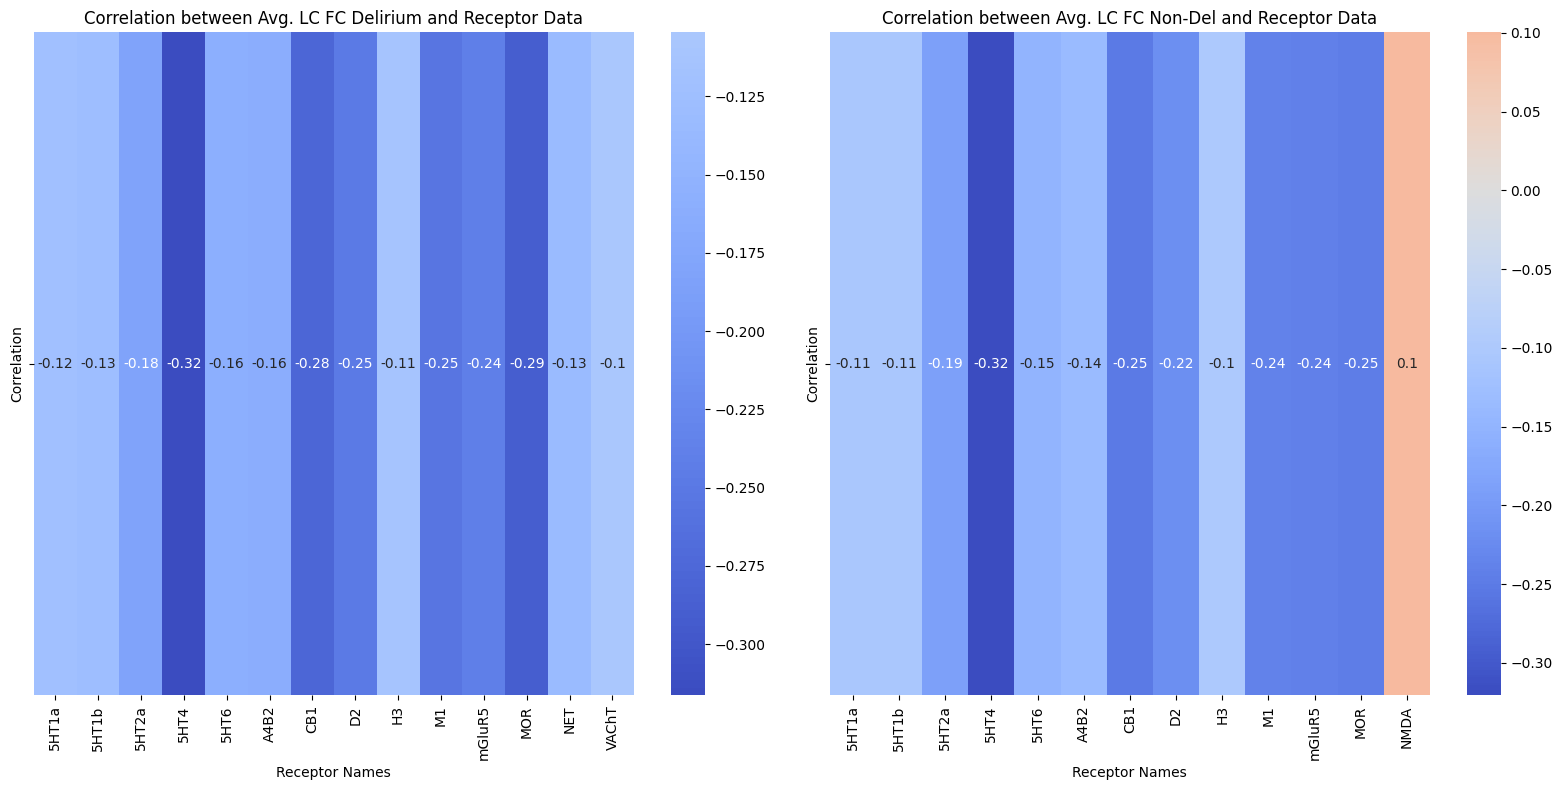

In [174]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define the name suffix for the receptor data
name_suffix ='LC FC'
data1 = np.mean(avg_fc_lc_del, axis=0)
data2 = np.mean(avg_fc_lc_nondel, axis=0)

#data1 = avg_fc_lc_del
#data2 = avg_fc_lc_nondel

# Calculate the correlation between avg_pc_del and receptor_data
[correlations_del,pvalue_del]=stats.permtest_pearsonr(receptor_data,data1, n_perm=1000)

# Calculate the correlation between avg nondel LC FC and receptor_data
[correlations_nondel,pvalue_nondel]=stats.permtest_pearsonr(receptor_data,data2, n_perm=1000)

# Create DataFrames for easier plotting
# Create DataFrames for easier plotting
correlation_df_del_fc = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_del,
    'P-Value Permuted': pvalue_del
})

correlation_df_nondel_fc = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_nondel,
    'P-Value Permuted': pvalue_nondel
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_del = correlation_df_del_fc[correlation_df_del_fc['P-Value Permuted'] < significance_threshold]
significant_results_nondel = correlation_df_nondel_fc[correlation_df_nondel_fc['P-Value Permuted'] < significance_threshold]
# Plot the correlation matrices side by side
# Create dynamic titles
title_del = f'Correlation between Avg. {name_suffix} Delirium and Receptor Data'
title_nondel = f'Correlation between Avg. {name_suffix} Non-Del and Receptor Data'

# Ensure significant_results_del and significant_results_nondel contain numeric data for plotting
if 'Correlation' in significant_results_del.columns and 'Correlation' in significant_results_nondel.columns:
    correlation_values_del = significant_results_del[['Correlation']].astype(float).T  # Transpose for heatmap
    correlation_values_nondel = significant_results_nondel[['Correlation']].astype(float).T  # Transpose for heatmap
else:
    raise ValueError("One of the significant_results DataFrames does not contain a 'Correlation' column.")

# Create subplots for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for significant_results_del
sns.heatmap(correlation_values_del, annot=True, cmap='coolwarm', center=0,
            xticklabels=significant_results_del['Receptor'].values, ax=axes[0])
axes[0].set_title(title_del)
axes[0].set_xlabel('Receptor Names')


# Heatmap for significant_results_nondel
sns.heatmap(correlation_values_nondel, annot=True, cmap='coolwarm', center=0,
            xticklabels=significant_results_nondel['Receptor'].values, ax=axes[1])
axes[1].set_title(title_nondel)
axes[1].set_xlabel('Receptor Names')


plt.tight_layout()
plt.show()


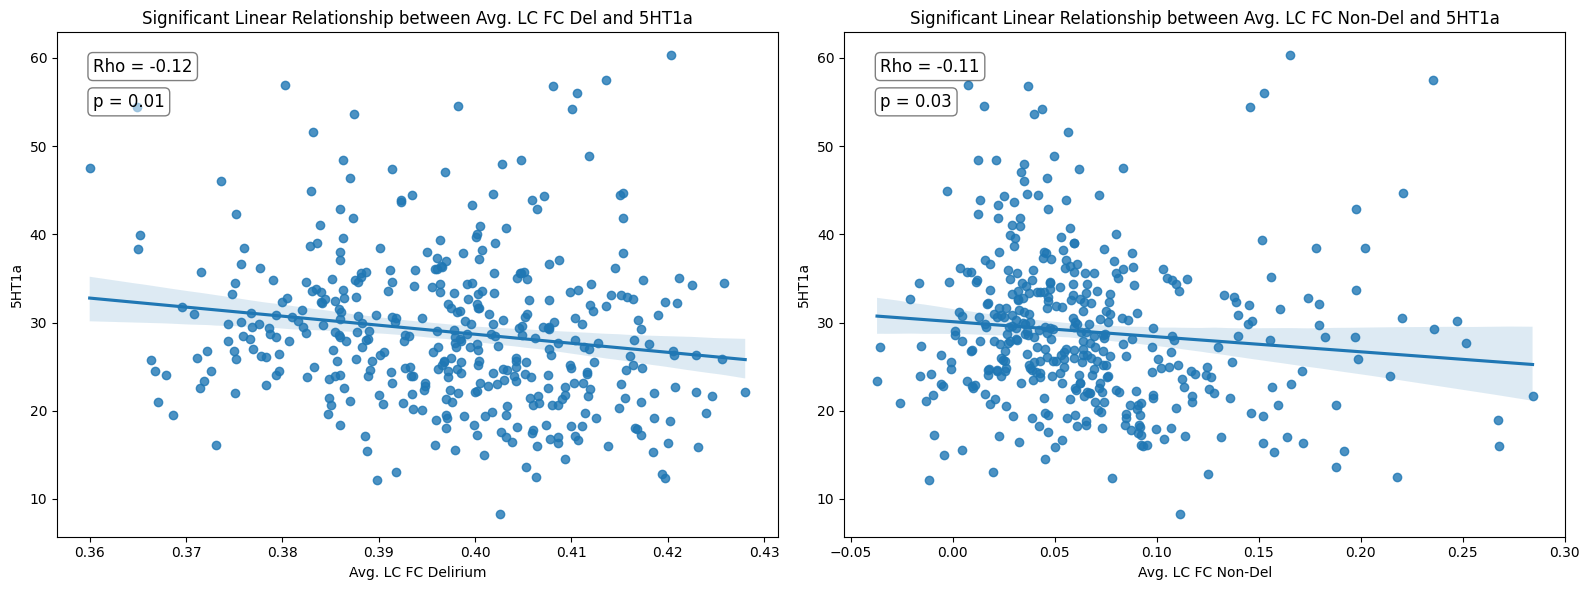

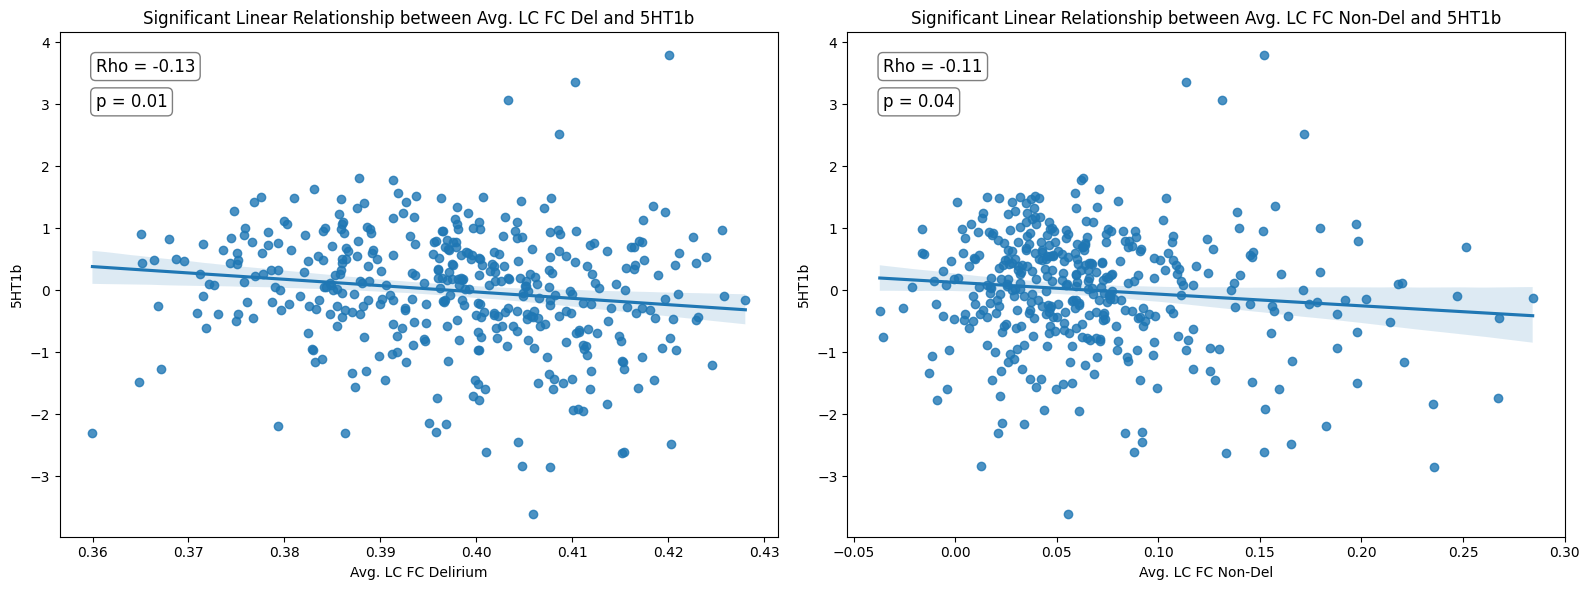

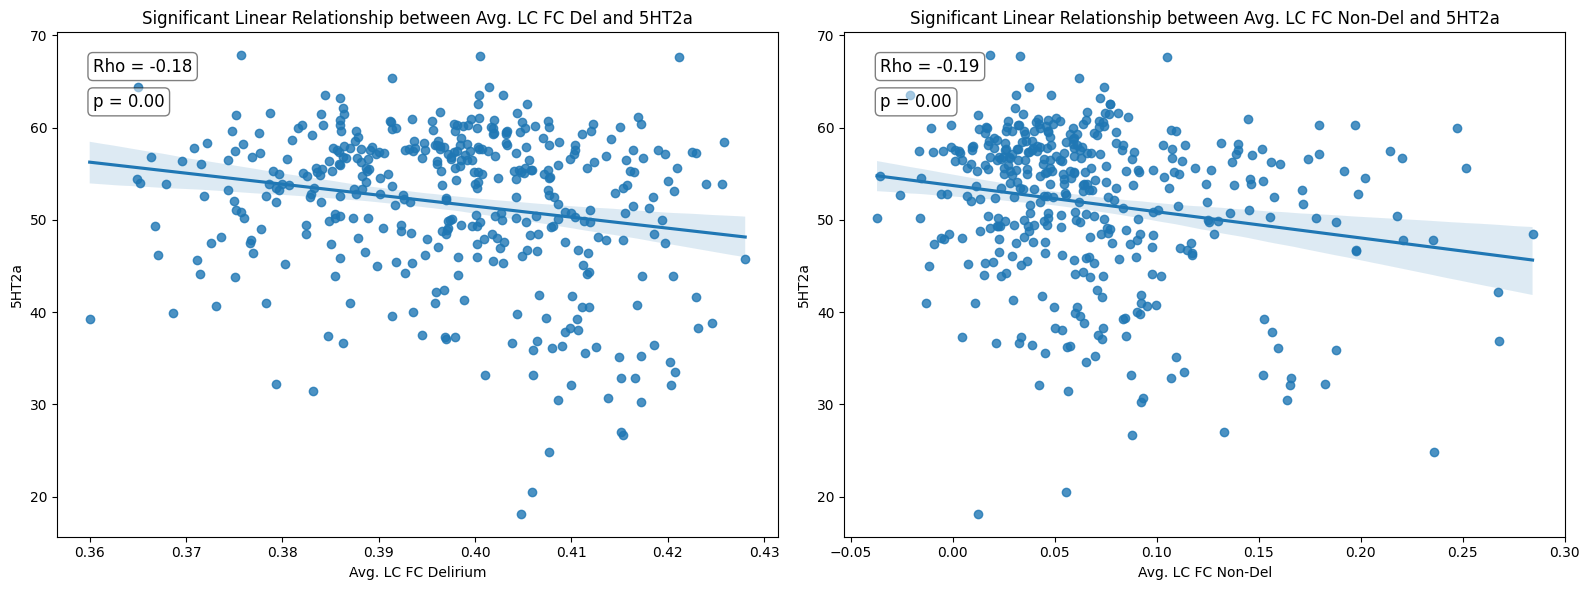

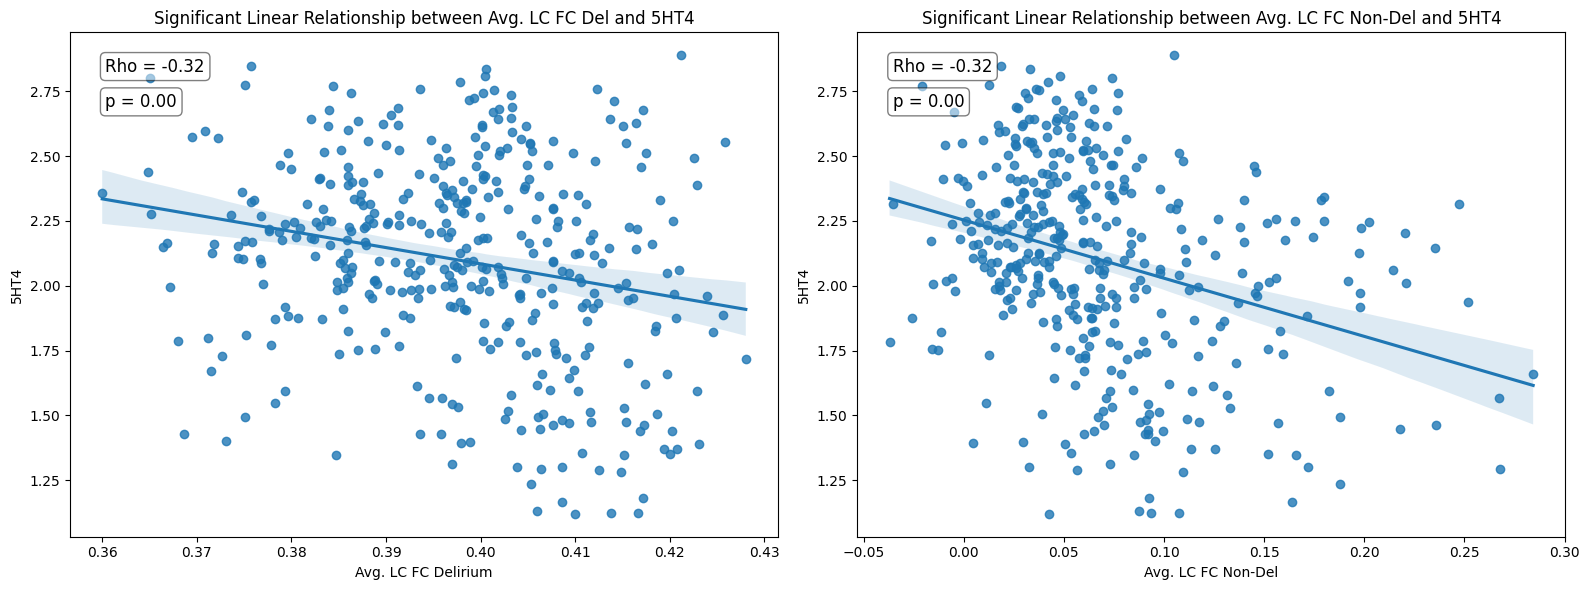

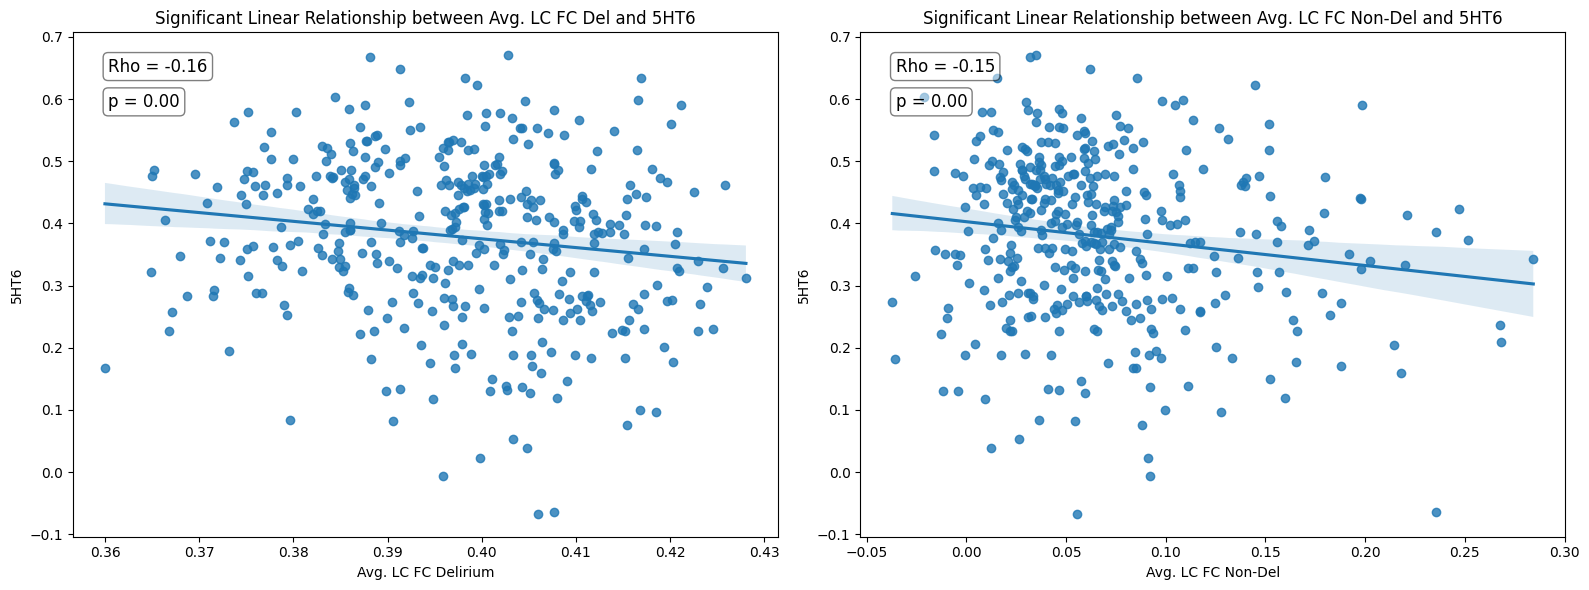

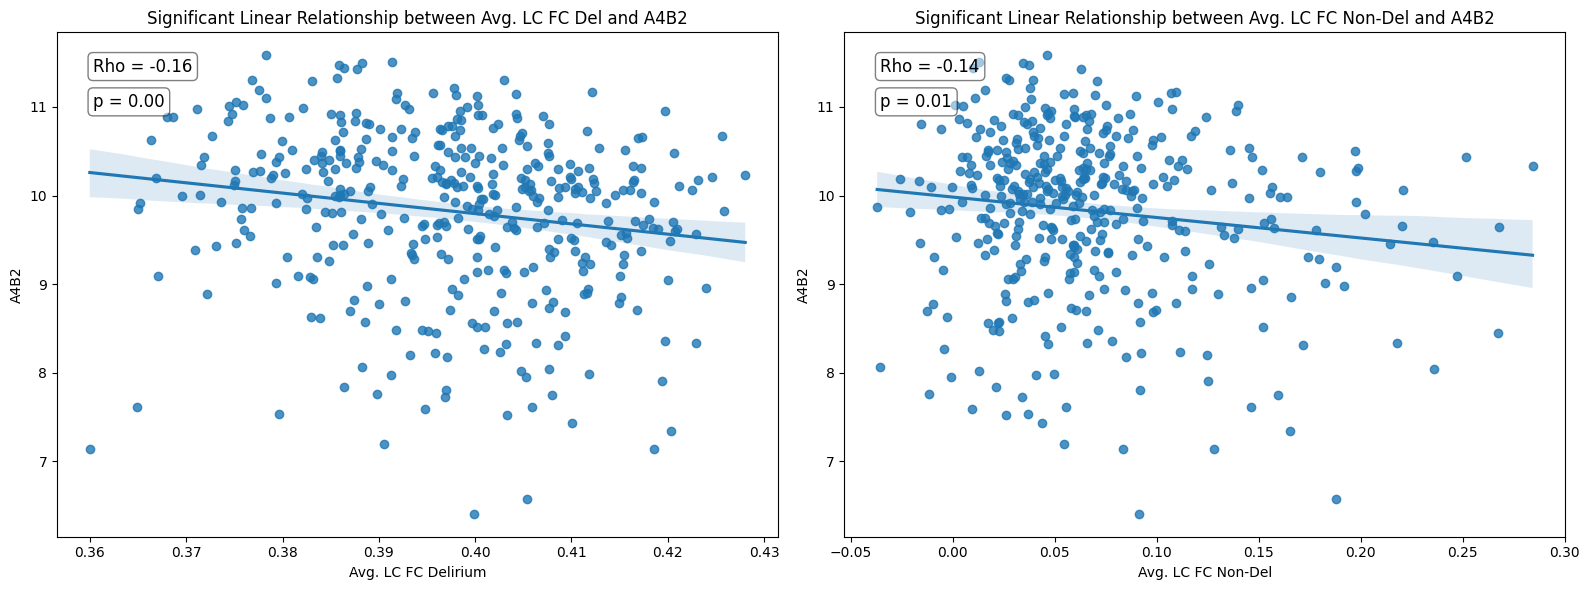

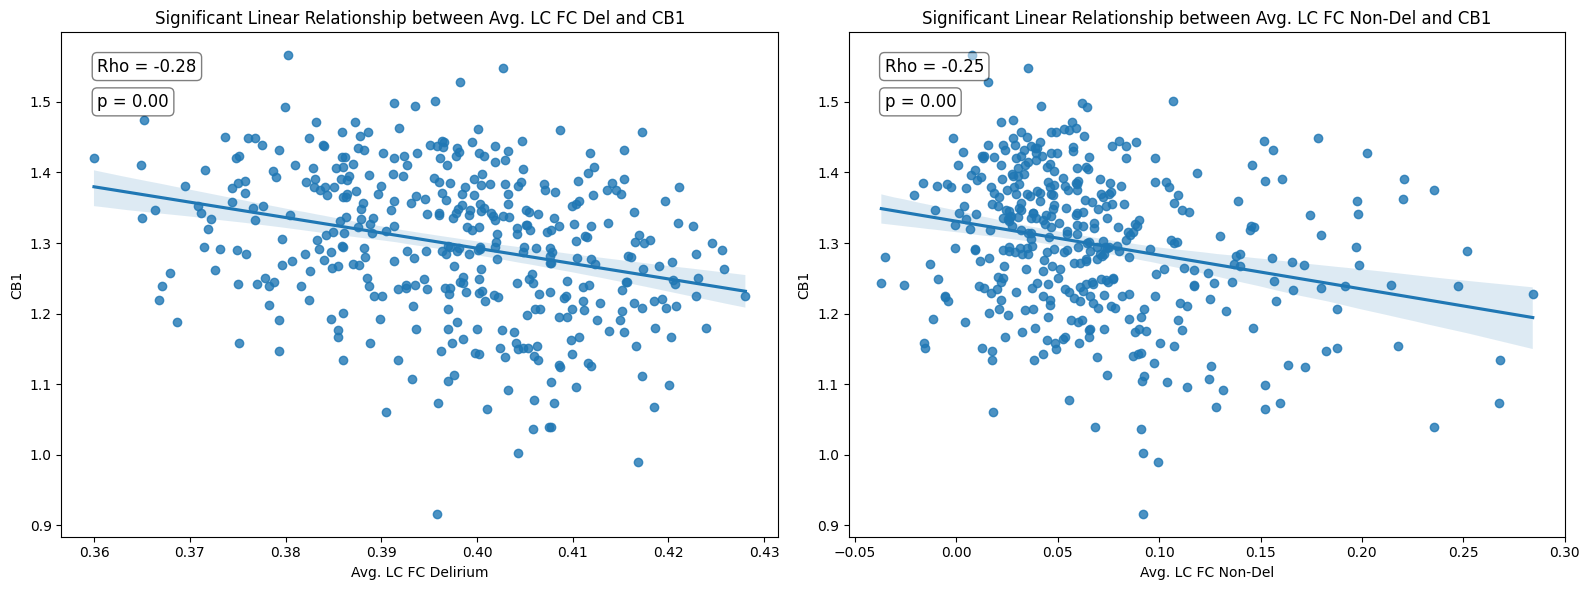

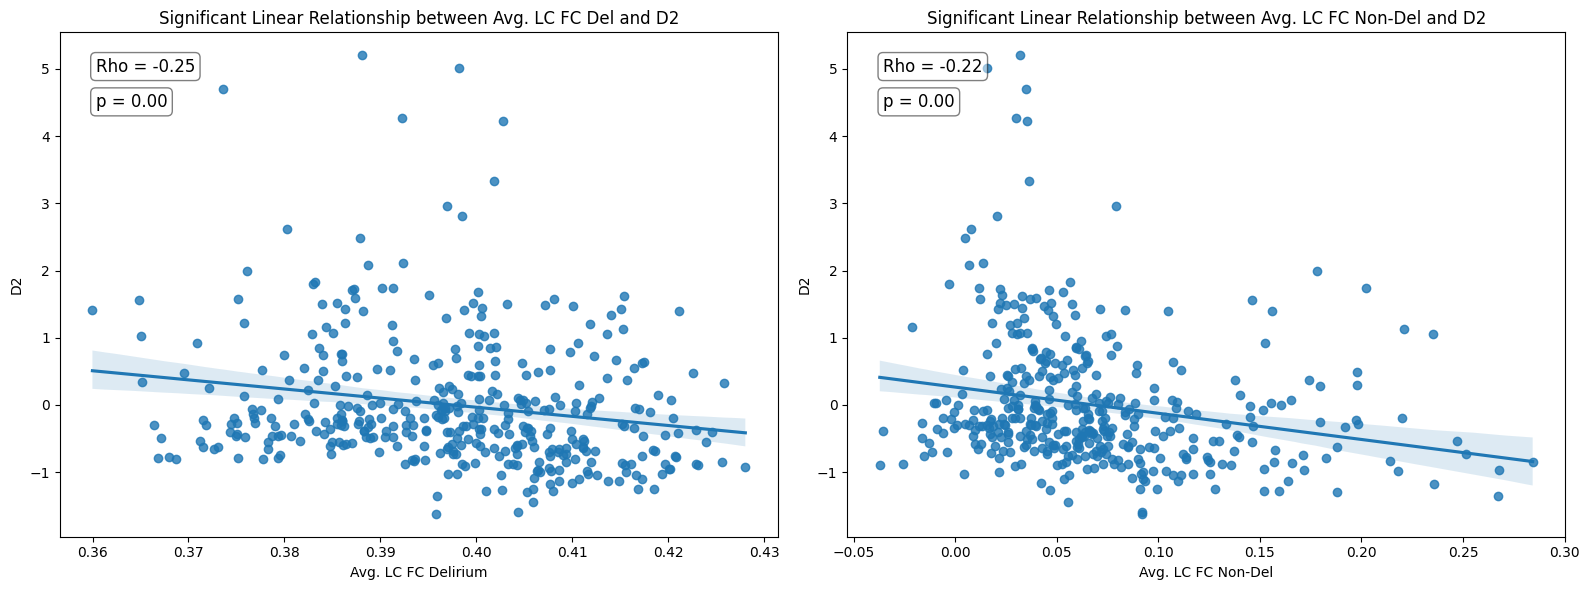

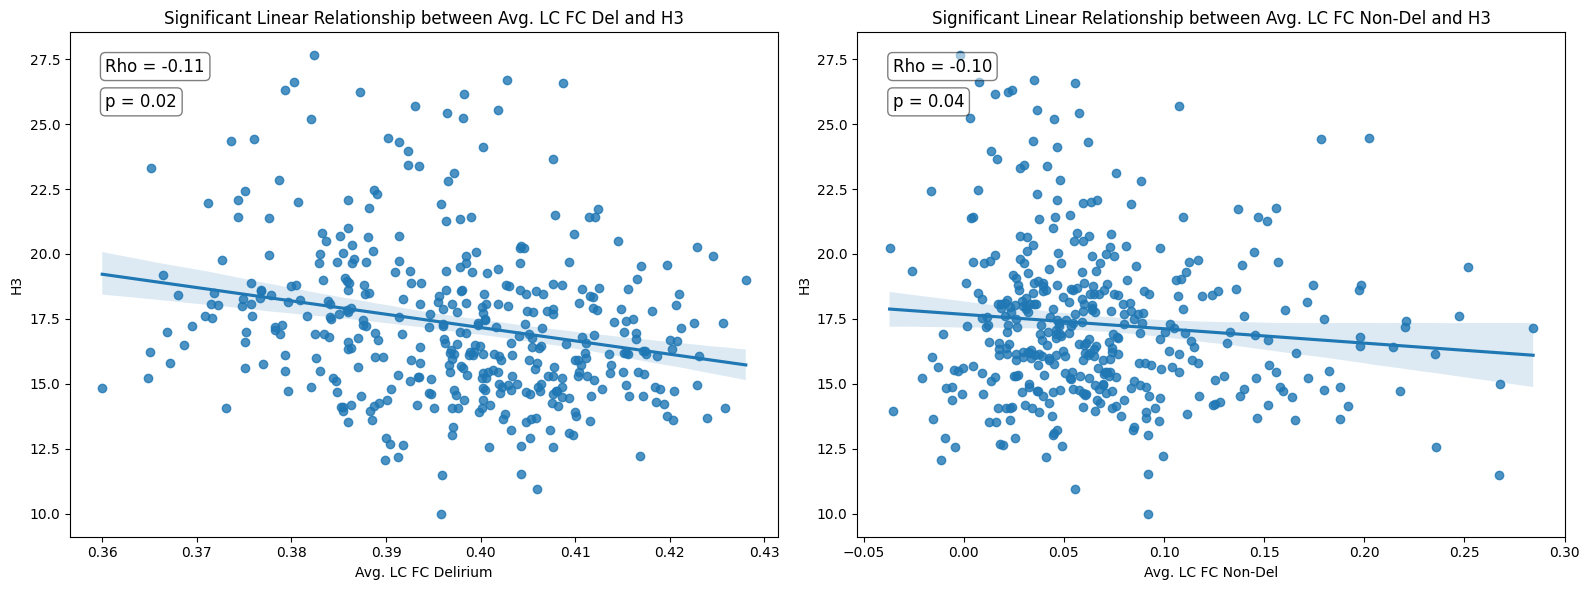

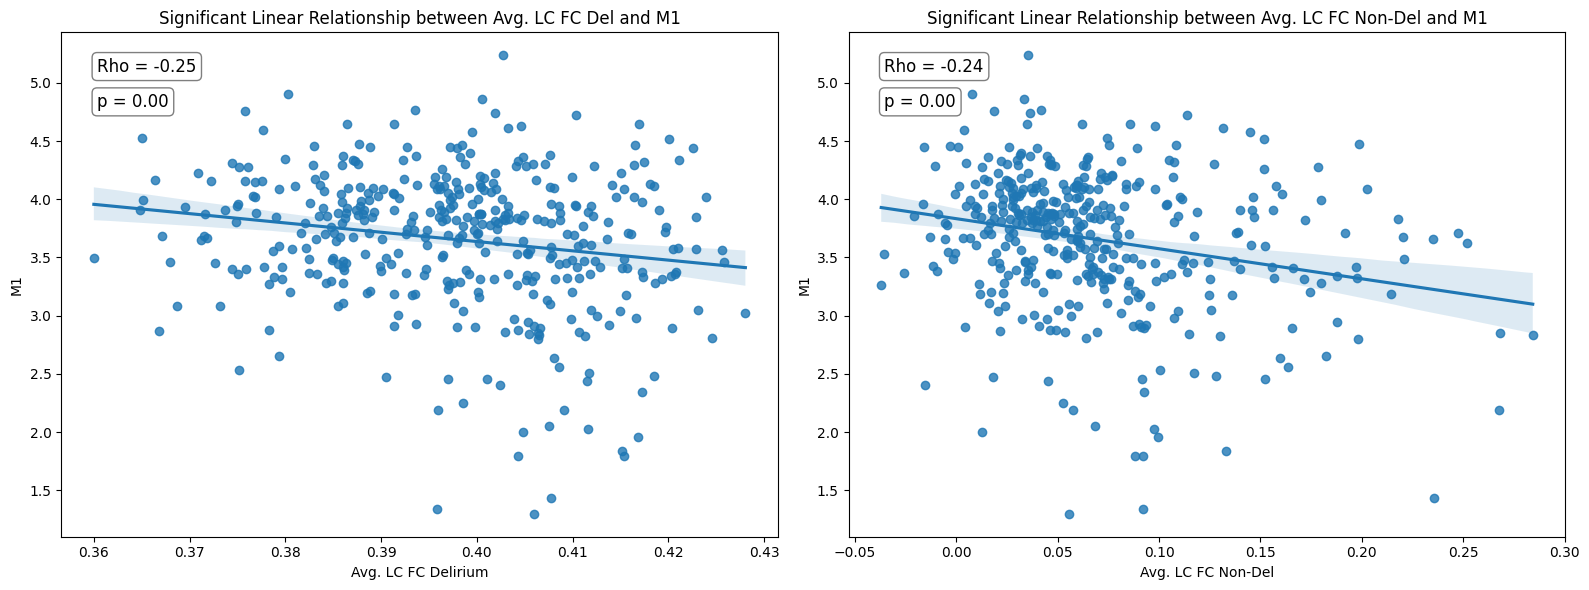

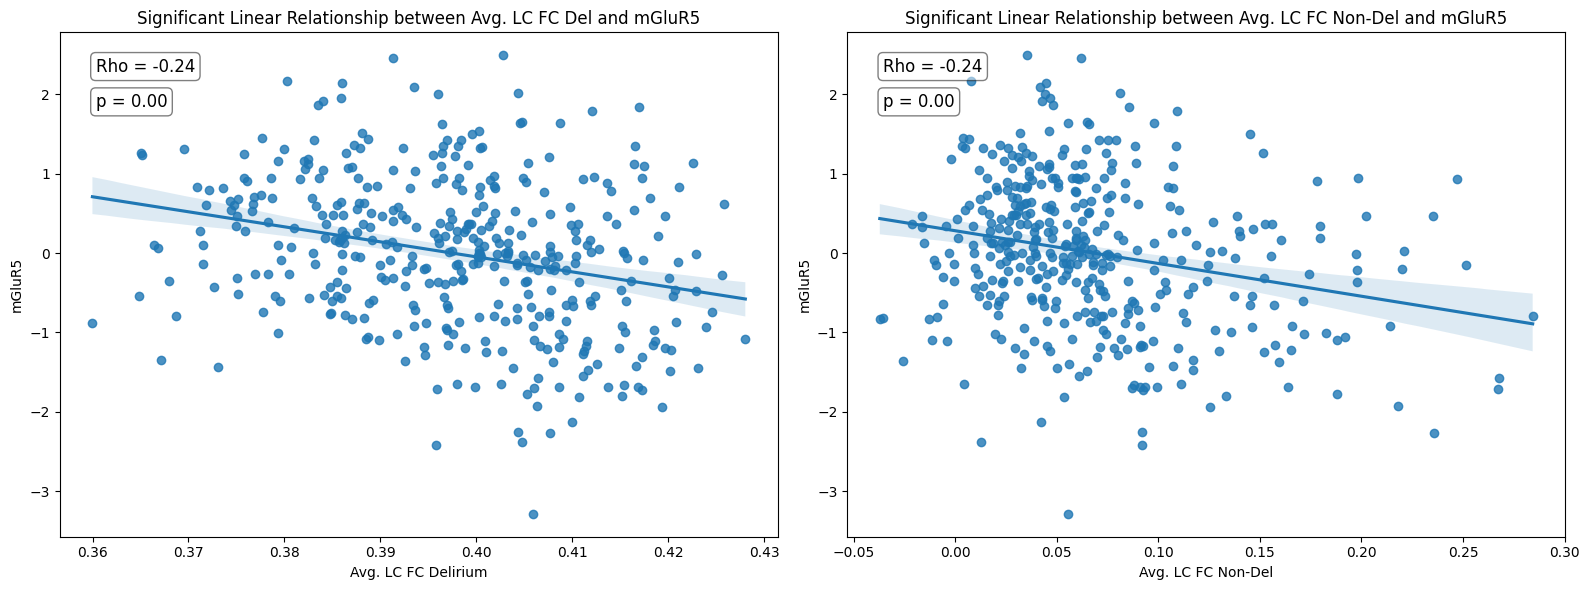

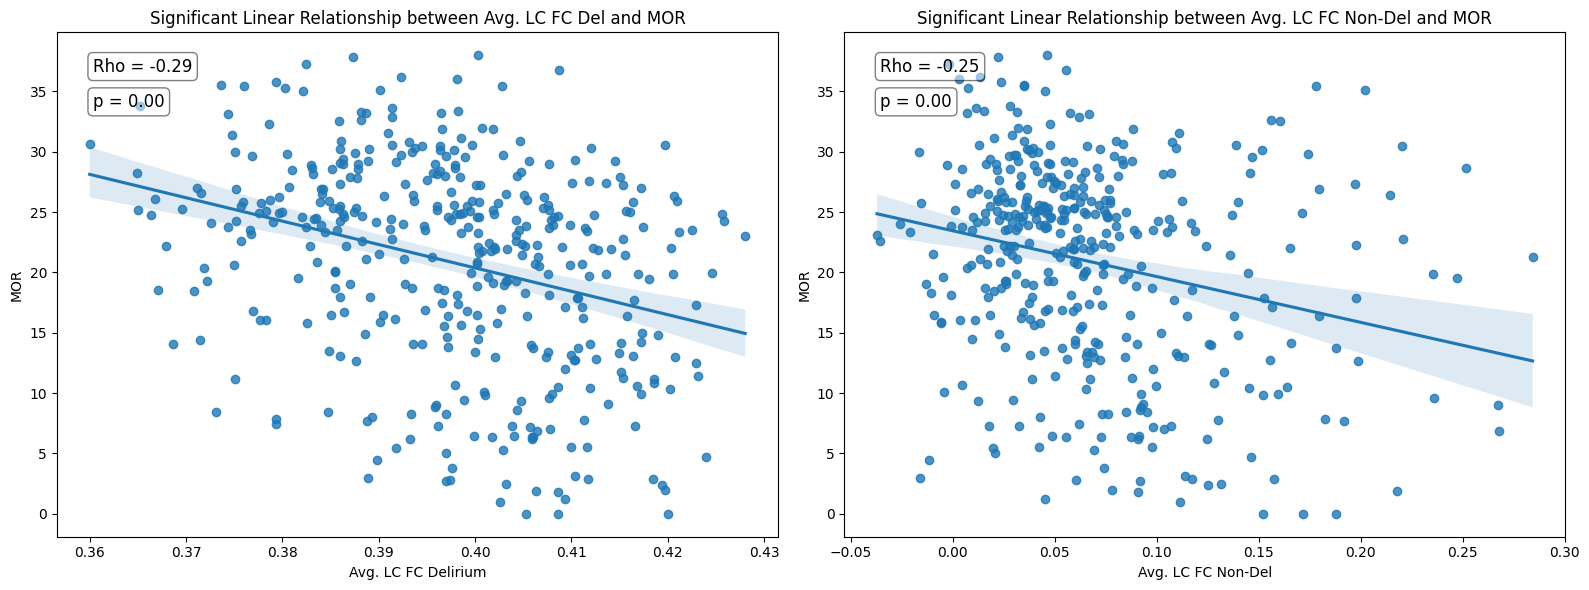

Skipping receptor NMDA for Avg. PC Del as it is not significant.


In [175]:
# Plot the linear relationships side by side for each receptor
# Iterate over significant receptors for both del and nondel
for receptor in significant_results_nondel['Receptor']:
    i = np.where(receptor_names == receptor)[0][0]  # Find the corresponding index in receptor_names
    
    # Check if receptor exists in significant_results_del
    if receptor not in significant_results_del['Receptor'].values:
        print(f"Skipping receptor {receptor} for Avg. PC Del as it is not significant.")
        continue
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot for Avg. PC Del
    sns.regplot(x=mean_pc_del.flatten(), y=receptor_data[:, i], ax=axes[0])
    axes[0].set_xlabel(f'Avg. {name_suffix} Delirium')
    axes[0].set_ylabel(receptor)
    axes[0].set_title(f'Significant Linear Relationship between Avg. {name_suffix} Del and {receptor}')
    
    # Calculate correlation for Avg. PC Del
    rho_del = significant_results_del[significant_results_del['Receptor'] == receptor]['Correlation'].values[0]
    pval_del = significant_results_del[significant_results_del['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Del
    axes[0].text(0.05, 0.95, f'Rho = {rho_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[0].text(0.05, 0.88, f'p = {pval_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Plot for Avg. PC Non-Del
    sns.regplot(x=data2.flatten(), y=receptor_data[:, i], ax=axes[1])
    axes[1].set_xlabel(f'Avg. {name_suffix} Non-Del')
    axes[1].set_ylabel(receptor)
    axes[1].set_title(f'Significant Linear Relationship between Avg. {name_suffix} Non-Del and {receptor}')
    
    # Calculate correlation for Avg. PC Non-Del
    rho_nondel = significant_results_nondel[significant_results_nondel['Receptor'] == receptor]['Correlation'].values[0]
    pval_nondel = significant_results_nondel[significant_results_nondel['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Non-Del
    axes[1].text(0.05, 0.95, f'Rho = {rho_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[1].text(0.05, 0.88, f'p = {pval_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

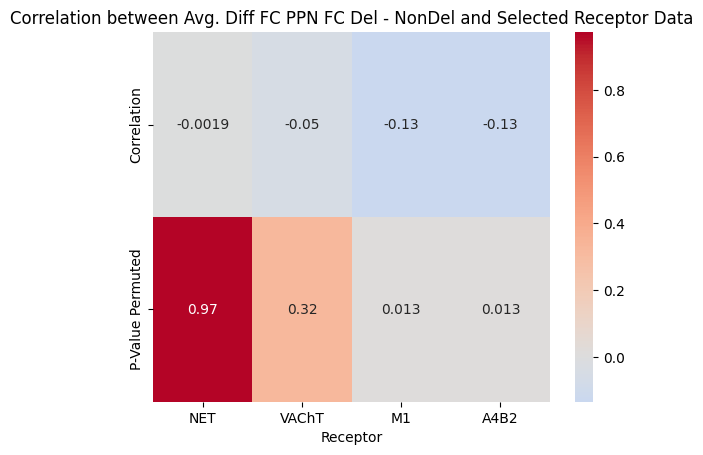

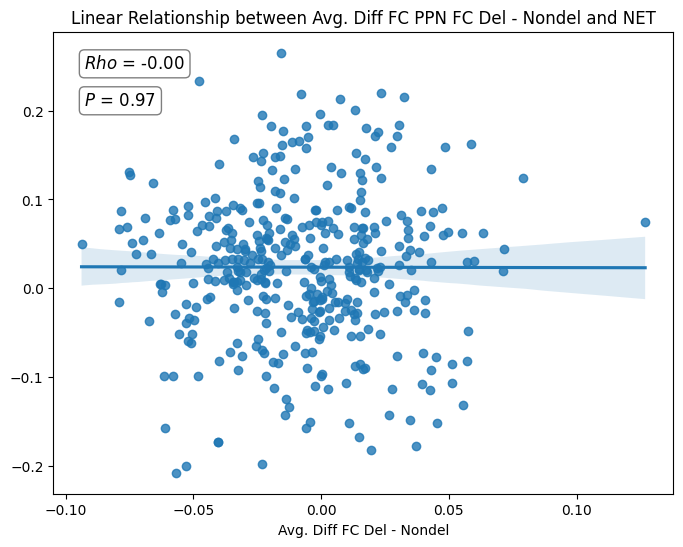

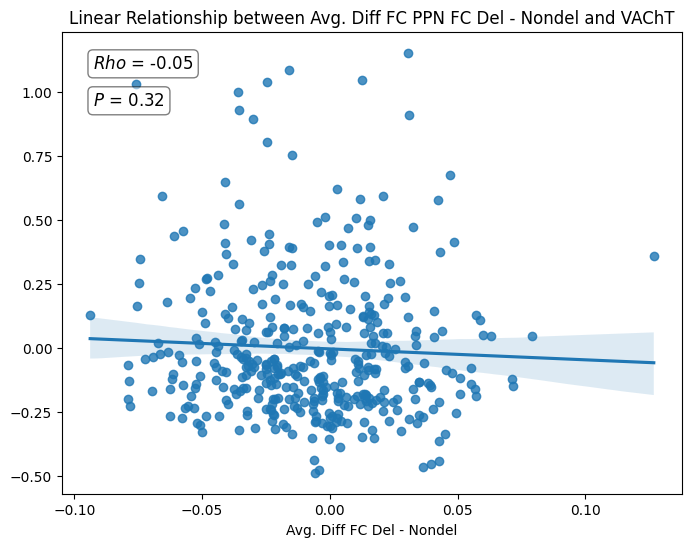

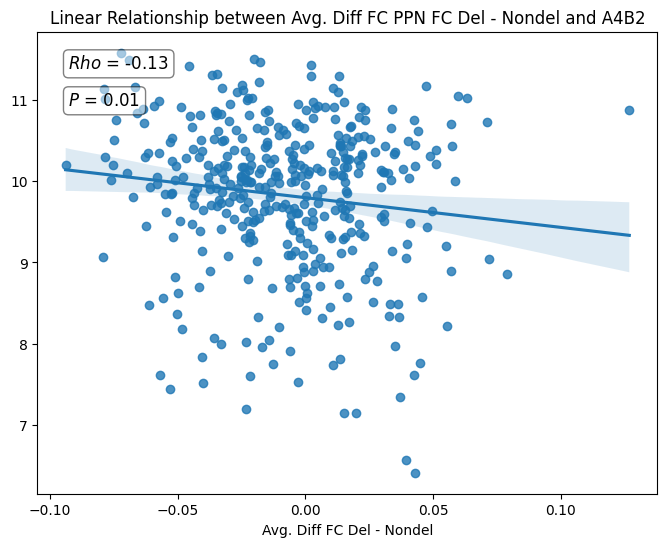

In [129]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# look at difference in FC for LC between del and non del
#diff_data = np.mean(avg_fc_lc_del, axis=0) - np.mean(avg_fc_lc_nondel, axis=0)
#diff_data = np.mean(avg_fc_nbm_del, axis=0) - np.mean(avg_fc_nbm_nondel, axis=0)
diff_data = np.mean(avg_fc_ppn_del, axis=0) - np.mean(avg_fc_ppn_nondel, axis=0)
name_suffix ='PPN FC'
# Calculate the correlation between diff in mean fc LC del - non-del and receptor_data
[correlations_diff_all,pvalue_diff_all]=stats.permtest_pearsonr(receptor_data,diff_data,n_perm=1000)
# Select specific receptors
selected_receptors = ['NET','VAChT', 'M1','A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]
# Calculate the correlation for the selected receptors
[correlations_diff_select,pvalue_diff_select]=stats.permtest_pearsonr(receptor_data[:,selected_indices],diff_data,n_perm=1000)

# Create DataFrames for easier plotting
# Create DataFrames for easier plotting
correlation_df_diff_all = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_diff_all,
    'P-Value Permuted': pvalue_diff_all})

correlation_df_diff_select = pd.DataFrame({
    'Receptor': selected_receptors,
    'Correlation': correlations_diff_select,
    'P-Value Permuted': pvalue_diff_select
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_select = correlation_df_diff_select[correlation_df_diff_select['P-Value Permuted'] < significance_threshold]


# Plot the correlation matrix
sns.heatmap(correlation_df_diff_select.set_index('Receptor').T, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation between Avg. Diff FC {name_suffix} Del - NonDel and Selected Receptor Data')
plt.show()

# Plot the linear relationship for each selected receptor
for i, receptor in enumerate(selected_receptors):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=diff_data.flatten(), y=receptor_data[:, selected_indices[i]])
    plt.xlabel('Avg. Diff FC Del - Nondel')
    plt.title(f'Linear Relationship between Avg. Diff FC {name_suffix} Del - Nondel and {receptor}')
    
        # Calculate correlation
    rho = correlation_df_diff_select[correlation_df_diff_select['Receptor'] == receptor]['Correlation'].values[0]
    pval= correlation_df_diff_select[correlation_df_diff_select['Receptor'] == receptor]['P-Value Permuted'].values[0]
    plt.text(0.05, 0.95, f'$Rho$ = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.87, f'$P$ = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.show()

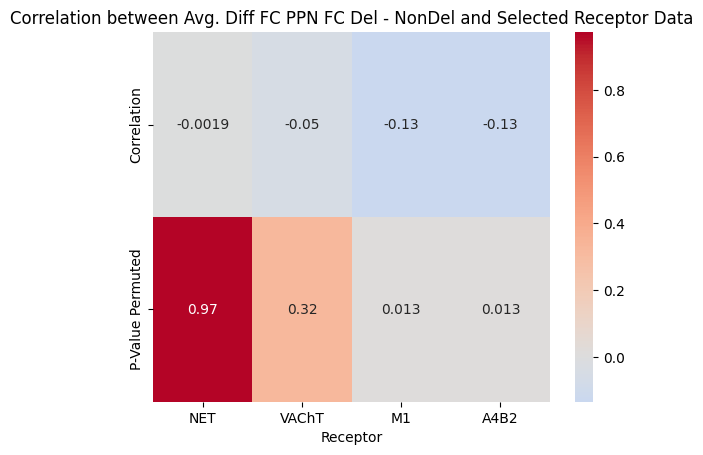

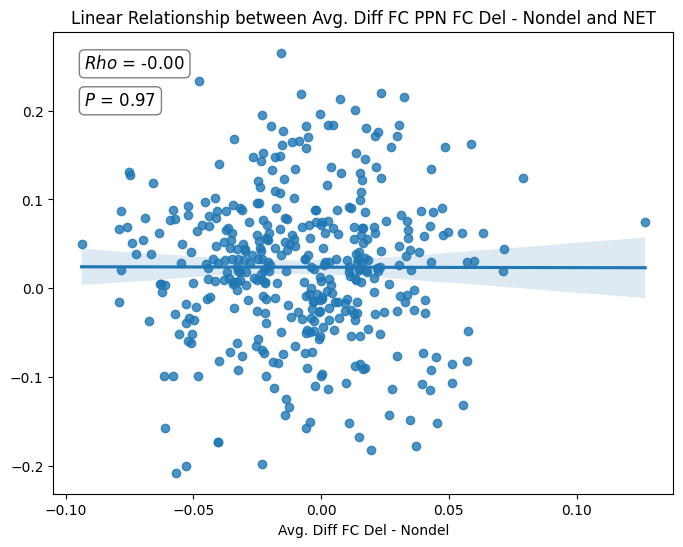

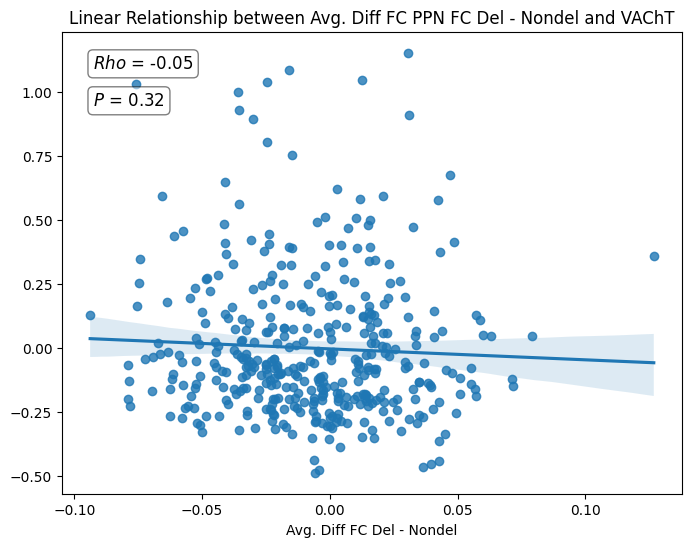

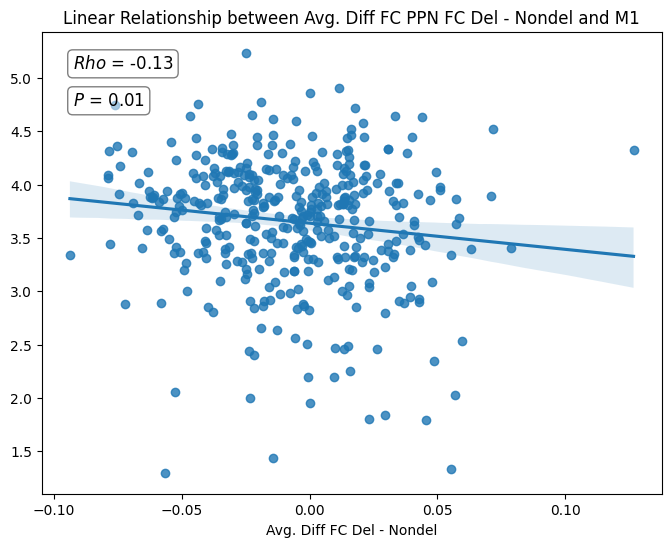

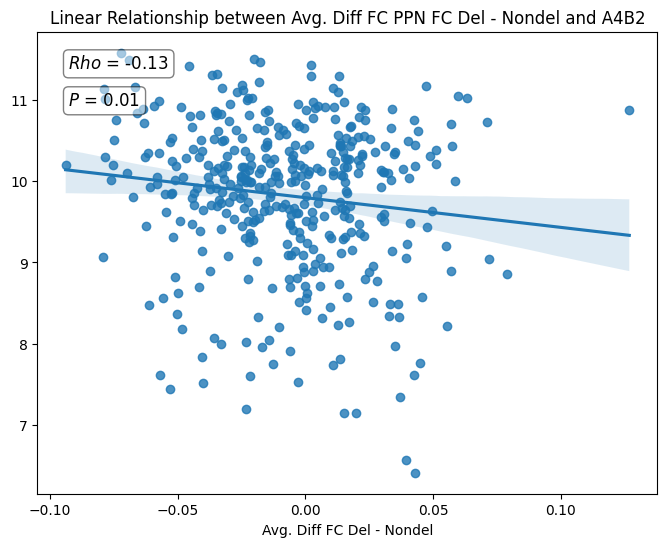

In [176]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# look at difference in FC for LC between del and non del
#diff_data = np.mean(avg_fc_lc_del, axis=0) - np.mean(avg_fc_lc_nondel, axis=0)
#diff_data = np.mean(avg_fc_nbm_del, axis=0) - np.mean(avg_fc_nbm_nondel, axis=0)
diff_data = np.mean(avg_fc_ppn_del, axis=0) - np.mean(avg_fc_ppn_nondel, axis=0)
name_suffix ='PPN FC'
# Calculate the correlation between diff in mean fc LC del - non-del and receptor_data
[correlations_diff_all,pvalue_diff_all]=stats.permtest_pearsonr(receptor_data,diff_data,n_perm=1000)
# Select specific receptors
selected_receptors = ['NET','VAChT', 'M1','A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]
# Calculate the correlation for the selected receptors
[correlations_diff_select,pvalue_diff_select]=stats.permtest_pearsonr(receptor_data[:,selected_indices],diff_data,n_perm=1000)

# Create DataFrames for easier plotting
# Create DataFrames for easier plotting
correlation_df_diff_all = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': correlations_diff_all,
    'P-Value Permuted': pvalue_diff_all})

correlation_df_diff_select = pd.DataFrame({
    'Receptor': selected_receptors,
    'Correlation': correlations_diff_select,
    'P-Value Permuted': pvalue_diff_select
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_select = correlation_df_diff_select[correlation_df_diff_select['P-Value Permuted'] < significance_threshold]


# Plot the correlation matrix
sns.heatmap(correlation_df_diff_select.set_index('Receptor').T, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation between Avg. Diff FC {name_suffix} Del - NonDel and Selected Receptor Data')
plt.show()

# Plot the linear relationship for each selected receptor
for i, receptor in enumerate(selected_receptors):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=diff_data.flatten(), y=receptor_data[:, selected_indices[i]])
    plt.xlabel('Avg. Diff FC Del - Nondel')
    plt.title(f'Linear Relationship between Avg. Diff FC {name_suffix} Del - Nondel and {receptor}')
    
        # Calculate correlation
    rho = correlation_df_diff_select[correlation_df_diff_select['Receptor'] == receptor]['Correlation'].values[0]
    pval= correlation_df_diff_select[correlation_df_diff_select['Receptor'] == receptor]['P-Value Permuted'].values[0]
    plt.text(0.05, 0.95, f'$Rho$ = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.87, f'$P$ = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.show()

In [177]:

#just get the significantly different regions for LC
#load in the sig. diff FC Delirium - Health for LC, NBM, PPN
sig_diff_lc_fc = np.genfromtxt(path + '/sig_diff_lc_fc.csv', delimiter=',')
sig_diff_nbm_fc = np.genfromtxt(path + '/sig_diff_nbm_fc.csv', delimiter=',')
sig_diff_ppn_fc = np.genfromtxt(path + '/sig_diff_ppn_fc.csv', delimiter=',')

In [131]:
print(sig_diff_lc_fc.shape)

(400,)


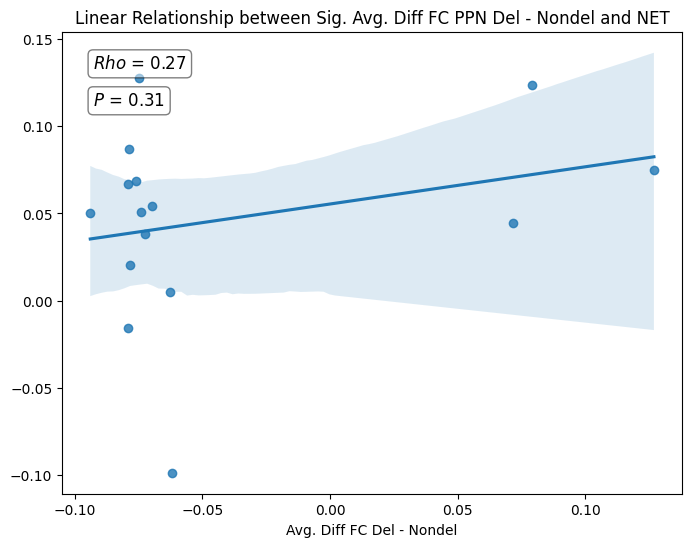

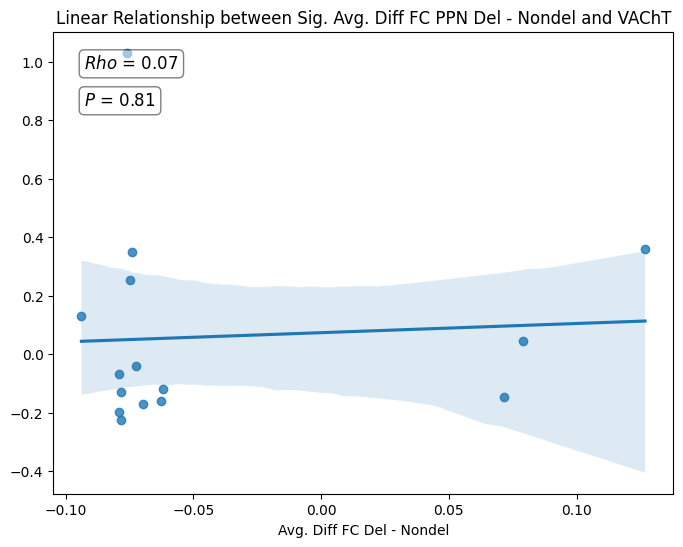

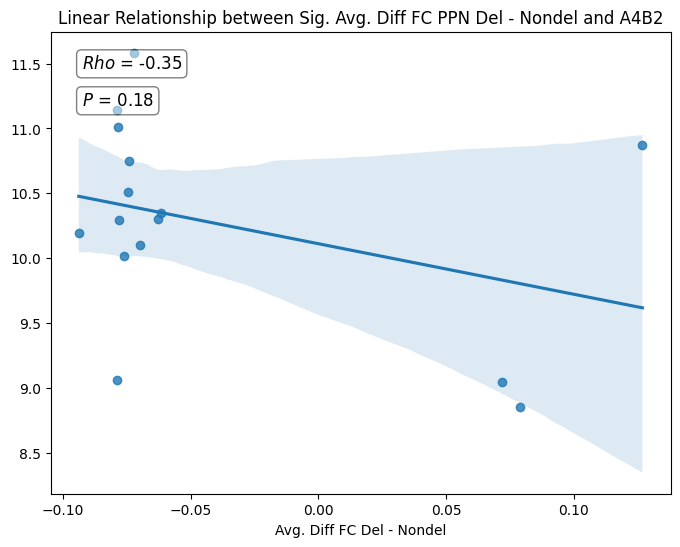

In [180]:
# look at only significantly different FC for LC between del and non del
data3 = sig_diff_ppn_fc
name_suffix="PPN"
# Filter out regions with zero values in data3
non_zero_indices = np.where(data3 != 0)[0]
filtered_receptor_data = receptor_data[non_zero_indices, :]
filtered_data3 = data3[non_zero_indices]

# Select specific receptors
selected_receptors = ['NET', 'VAChT', 'M1', 'A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]

# Calculate the correlation for the selected receptors
#correlations_selected = np.corrcoef(filtered_receptor_data[:, selected_indices].T, filtered_data3.T)

[correlations_selected,pvalue_selected]=stats.permtest_pearsonr(filtered_receptor_data[:, selected_indices],filtered_data3,n_perm=1000)
# Extract the relevant part of the correlation matrix
correlation_df_selected = pd.DataFrame({
    'Receptor': selected_receptors,
    'Correlation': correlations_selected,
    'P-Value Permuted':pvalue_selected})

# Create a DataFrame for easier plotting
#correlation_df_selected = pd.DataFrame(correlations_selected, index=selected_receptors, columns=['Correlation'])

# Plot the correlation matrix
# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_select = correlation_df_selected[correlation_df_selected['P-Value Permuted'] < significance_threshold]


# Plot the correlation matrix
sns.heatmap(correlation_df_selected.set_index('Receptor').T, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation between Sig. Avg. Diff FC {name_suffix} Del - NonDel and Selected Receptor Data')
plt.show()

# Plot the linear relationship for each selected receptor
for i, receptor in enumerate(selected_receptors):
    # Filter out rows where x or y values are 0
    x_data = data3.flatten()
    y_data = receptor_data[:, selected_indices[i]]
    mask = (x_data != 0) & (y_data != 0)  # Create a mask to exclude zeros
    x_filtered = x_data[mask]
    y_filtered = y_data[mask]
    
    # Plot the filtered data
    plt.figure(figsize=(8, 6))
    sns.regplot(x=x_filtered, y=y_filtered)
    plt.xlabel('Avg. Diff FC Del - Nondel')
    plt.title(f'Linear Relationship between Sig. Avg. Diff FC {name_suffix} Del - Nondel and {receptor}')
    
    # Calculate correlation
    rho = correlation_df_selected[correlation_df_selected['Receptor'] == receptor]['Correlation'].values[0]
    pval = correlation_df_selected[correlation_df_selected['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text
    plt.text(0.05, 0.95, f'$Rho$ = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.87, f'$P$ = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.show()


In [32]:
# look at only significantly different FC for LC between del and non del - so few regions that are significantly different
data3 = sig_diff_nbm_fc

# Filter out regions with zero values in data3
non_zero_indices = np.where(data3 != 0)[0]
filtered_receptor_data = receptor_data[non_zero_indices, :]
filtered_data3 = data3[non_zero_indices]

# Select specific receptors
selected_receptors = ['NET', 'VAChT', 'M1', 'A4B2']
selected_indices = [np.where(receptor_names == receptor)[0][0] for receptor in selected_receptors]

# Calculate the correlation for the selected receptors
correlations_selected = np.corrcoef(filtered_receptor_data[:, selected_indices].T, filtered_data3.T)

# Extract the relevant part of the correlation matrix
correlations_selected = correlations_selected[:-1, -1]

# Create a DataFrame for easier plotting
correlation_df_selected = pd.DataFrame(correlations_selected, index=selected_receptors, columns=['Correlation'])

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df_selected.T, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Sig Avg. Diff FC nbM Del - NonDel and Selected Receptor Data')
plt.show()

NameError: name 'sig_diff_nbm_fc' is not defined

In [ ]:
# Plot the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=selected_receptors, y=correlation_df_selected['Correlation'])
plt.title('Mean Receptor Distribution for Regions with Non-Zero Values in data3')
plt.xticks(rotation=90)
plt.show()

## Load in the LDA coefficient Results

see if there's a relationship between the LDA coefficient projected dFC results and the receptor distributions

In [164]:
# load in the relevant data
path = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400'
#path2 = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python'
# load the receptor LDA coefficients
#LDA_coeffs_weights_select_time_delirium_avg_dFC_mtd_nbm.csv
#lda_coefficient_weights_overtime_mtd_ppn.csv
lda_coeff = np.genfromtxt(path + '/LDA_coeffs_weights_select_time_delta_avg_dFC_mtd_ppn2.csv', delimiter=',', skip_header=1)
#lda_coeff = np.genfromtxt(path + '/lda_coefficient_weights_overtime_mtd_ppn.csv', delimiter=',', skip_header=1)
# name suffix
name_suffix='PPN avg delta dFC LDA'

print(lda_coeff.shape)

(502,)


In [165]:
# relationship between receptor data and LDA coefficients
# spin permutation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from netneurotools import stats

# Calculate the observed correlation
#observed_correlations = [pearsonr(analyse_data, receptor_data[:, i])[0] for i in range(receptor_data.shape[1])]

analyse_data = lda_coeff[0:400]  # Use the second column of lda_coeff as analyse_data
[corr,pvalue]=stats.permtest_pearsonr(analyse_data,receptor_data, n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted = pd.DataFrame({
    'Receptor': receptor_names,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted[correlation_permuted['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(correlation_permuted)
#print(significant_results)

   Receptor  Correlation  P-Value Permuted
0     5HT1a    -0.015016          0.786214
1     5HT1b    -0.011922          0.802198
2     5HT2a    -0.028985          0.558442
3      5HT4    -0.011452          0.816184
4      5HT6     0.007321          0.897103
5      5HTT    -0.019774          0.714286
6      A4B2    -0.026466          0.586414
7       CB1     0.037982          0.467532
8        D1    -0.001155          0.988012
9        D2    -0.018883          0.711289
10      DAT    -0.026414          0.613387
11    GABAa     0.031041          0.549451
12       H3     0.022170          0.654346
13       M1    -0.025889          0.591409
14   mGluR5     0.002865          0.959041
15      MOR     0.012584          0.794206
16      NET     0.012362          0.789211
17     NMDA     0.003885          0.946054
18    VAChT     0.007563          0.900100


Create the correlation plots

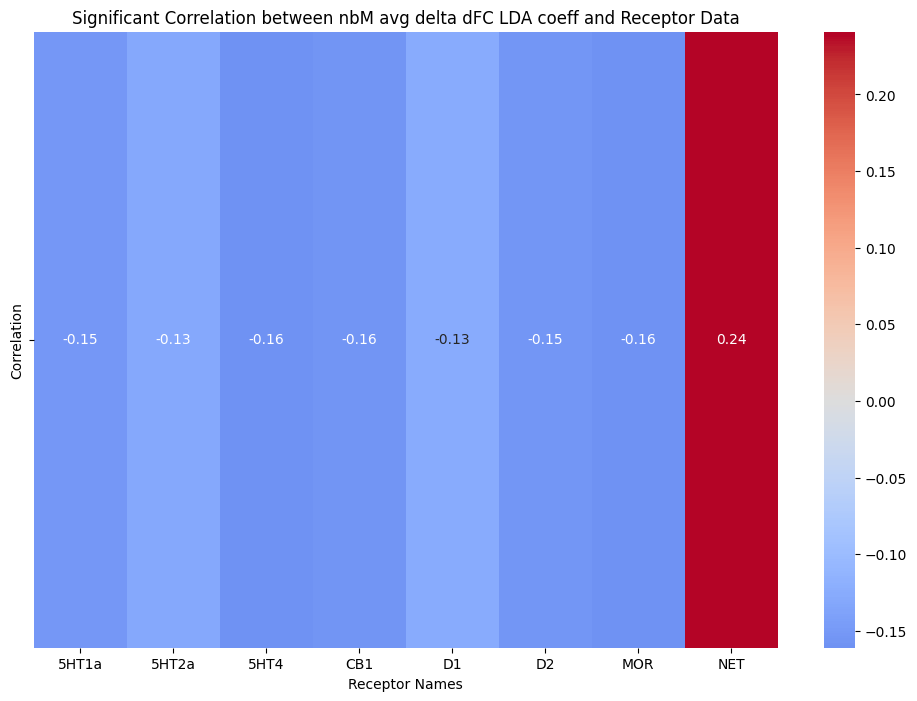

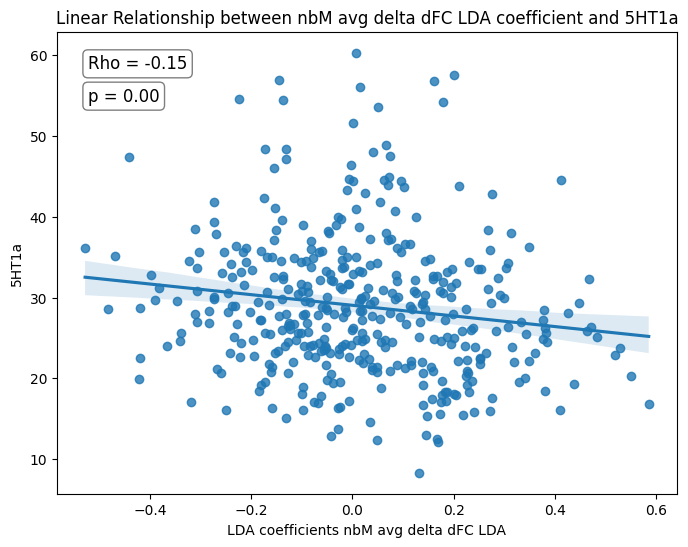

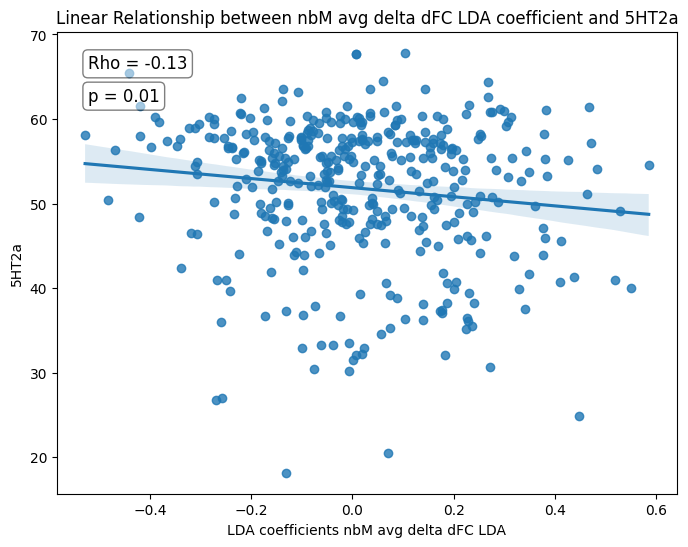

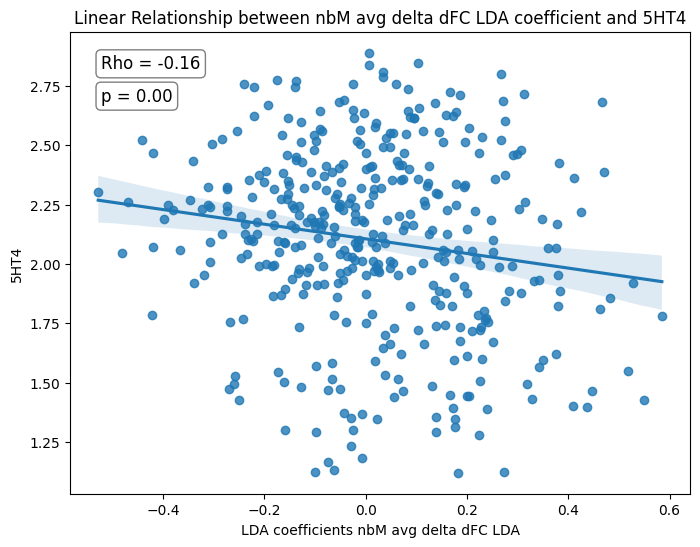

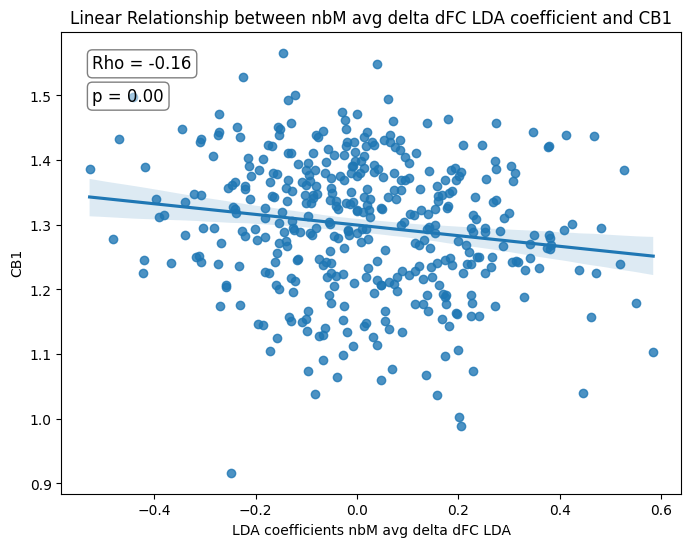

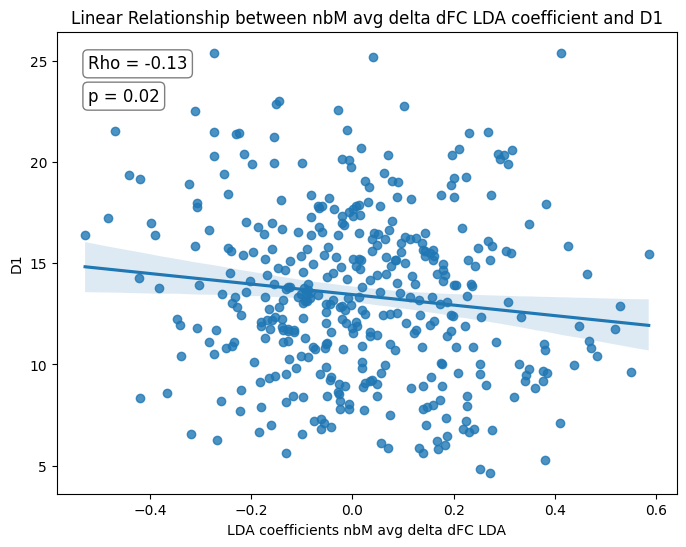

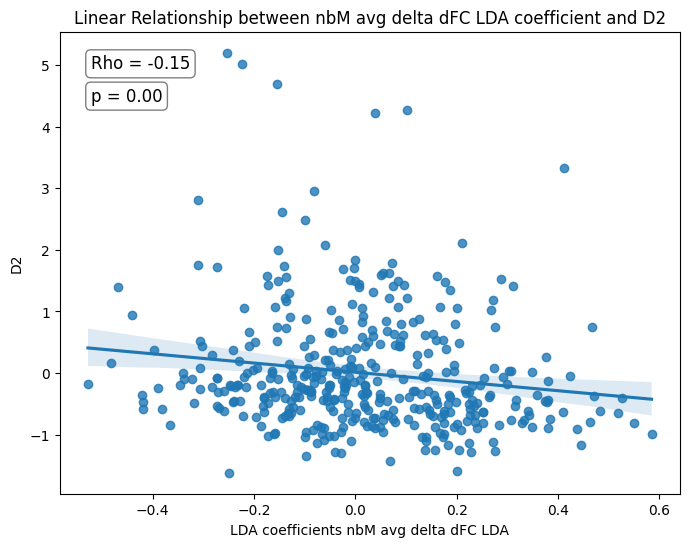

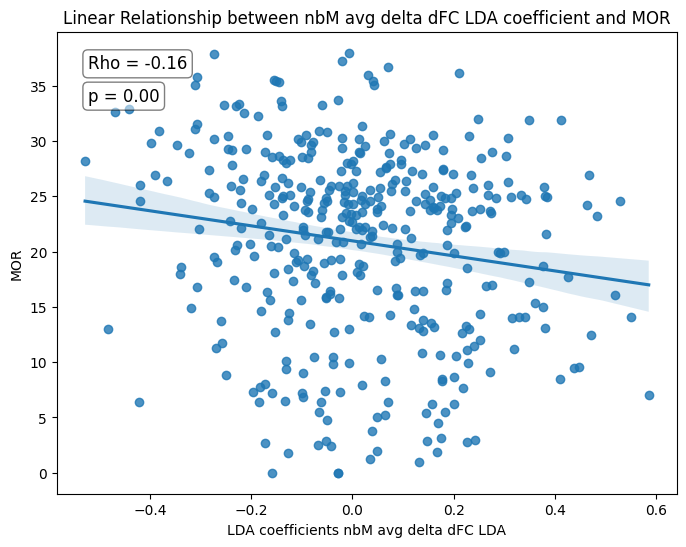

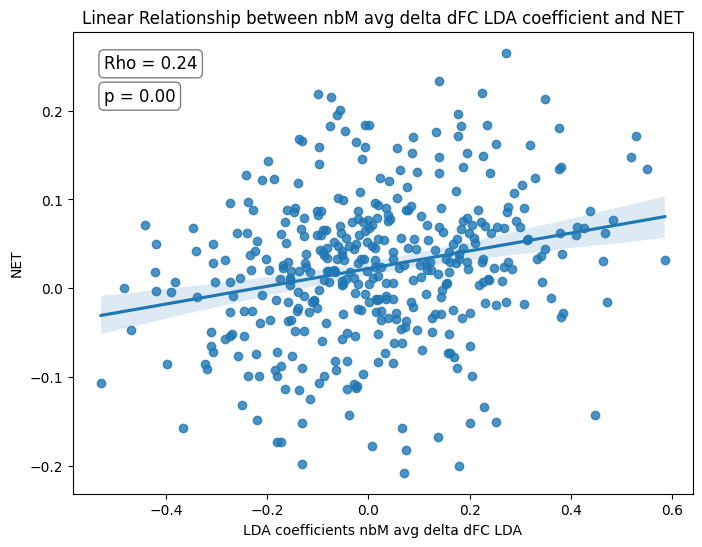

In [157]:
# Ensure significant_results contains numeric data for plotting
if 'Correlation' in significant_results.columns:
    correlation_values = significant_results[['Correlation']].astype(float)
else:
    raise ValueError("significant_results does not contain a 'Correlation' column.")

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_values.T, annot=True, cmap='coolwarm', center=0, xticklabels=significant_results['Receptor'])
plt.title(f'Significant Correlation between {name_suffix} coeff and Receptor Data')
plt.xlabel('Receptor Names')  # Add x-axis label
plt.show()

# Iterate over significant receptors
for receptor in significant_results.Receptor:  # Use the index of significant_results (receptor names)
    i = np.where(receptor_names == receptor)[0][0]  # Find the corresponding index in receptor_names
    
    plt.figure(figsize=(8, 6))
    sns.regplot(x=analyse_data.flatten(), y=receptor_data[:, i])
    plt.xlabel(f'LDA coefficients {name_suffix}')
    plt.ylabel(receptor)
    plt.title(f'Linear Relationship between {name_suffix} coefficient and {receptor}')
    
    # Calculate correlation
    rho = significant_results[significant_results['Receptor'] == receptor]['Correlation'].values[0]
    pval = significant_results[significant_results['Receptor'] == receptor]['P-Value Permuted'].values[0]
    
    plt.text(0.05, 0.95, f'Rho = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.88, f'p = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.show()

In [ ]:
from pathlib import Path

# Define the annotations directory
annotations_dir = Path('/Users/ntaylor/neuromaps-data/annotations')

# Create the directory if it doesn't exist
annotations_dir.mkdir(parents=True, exist_ok=True)
print(f"Annotations directory created at: {annotations_dir}")

Annotations directory created at: /Users/ntaylor/neuromaps-data/annotations


## Receptors of Interest Analysis
Select these receptors based upon relevant receptors that have closer or similar overlapping ages in the dataset

- **aghourian2017-feobv-MNI152-1mm**
    - PET tracer binding (SUVR) to VAChT (acetylcholine transporter)
        
        **Demographics**: N = 18, Age = 66.8 +/- 6.8
        
        *{‘source’: ‘aghourian2017’, ‘desc’: ‘feobv’, ‘space’: ‘MNI152’, ‘res’: ‘1mm’}*
        
- bebard2019-feobv-MNI152-1mm
    - PET tracer binding (SUVR) to VAChT (acetylcholine transporter)
        
        **Demographics**: N = 5, Age = 68.3 +/- 3.1
        
        *{‘source’: ‘bedard2019’, ‘desc’: ‘feobv’, ‘space’: ‘MNI152’, ‘res’: ‘1mm’}*
        
- spreng-feobv-MNI152-1mm
    - PET tracer binding (SUVR) to VAChT (acetylcholine transporter)
        
        **Demographics**: N = 3, Age = 66.6 +/- 0.94
        
        *{‘source’: ‘spreng’, ‘desc’: ‘feobv’, ‘space’: ‘MNI152’, ‘res’: ‘1mm’}*
        
- M1 receptor: **naganawa2020-lsn3172176-MNI152-1mm**
    - PET tracer binding (BPnd) to M1 (acetylcholine receptor)
    
    **Demographics**: N = 24, Age = 40.45 +/- 11.71
    
- **NET receptor: ding2010-mrb-MNI152-1mm**
    - PET tracer binding (BPnd) to NET (norepinephrine transporter)
        
        **Demographics**: N = 77, Age = 33.4 +/- 9.17
        
- **hesse2017-methylreboxetine-MNI152-3mm**
    - PET tracer binding (BPnd) to NET (norepinephrine transporter)
        
        **Demographics**: N = 10, Age = 33.3 (mean)

- **fazio2016-madam-MNI152-3mm**
    - PET tracer binding (BPnd) to 5-HTT (serotonin transporter)
    
    **Demographics**: N = 10, Age = 51-67
    
- **dukart2018-fpcit-MNI152-3mm**
    - SPECT tracer binding (SUVR) to DAT (dopamine transporter)
    
    **Demographics**: N = 174, Age = 61 +/- 11

- **rosaneto-abp688-MNI152-1mm**
    - *{‘source’: ‘rosaneto’, ‘desc’: ‘abp688’, ‘space’: ‘MNI152’, ‘res’: ‘1mm’}*
    
    **Full description**
    
    PET tracer binding (BPnd) to mGluR5 (glutamate receptor)
    
    **Demographics**: N = 22, Age = 67.9 +/- 9.6

In [166]:
# load in relevant data

import numpy as np
from netneurotools import datasets as nntdata
#from netneurotools import plotting
from matplotlib.colors import ListedColormap
from scipy.stats import zscore
from nilearn.datasets import fetch_atlas_schaefer_2018

path = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/PhD/Code/neuromaps'

scale = 'scale400'

schaefer = fetch_atlas_schaefer_2018(n_rois=400)
nnodes = len(schaefer['labels'])

# concatenate the receptors based of interest (relative similar age group)

receptors_csv = [#path+'/PET_parcellated/'+scale+'/5HT1a_way_hc36_savli.csv',
                 #path+'/PET_parcellated/'+scale+'/5HT1b_p943_hc22_savli.csv',
                 #path+'/PET_parcellated/'+scale+'/5HT1b_p943_hc65_gallezot.csv',
                 #path+'/PET_parcellated/'+scale+'/5HT2a_cimbi_hc29_beliveau.csv',
                 #path+'/PET_parcellated/'+scale+'/5HT4_sb20_hc59_beliveau.csv',
                 #path+'/PET_parcellated/'+scale+'/5HT6_gsk_hc30_radhakrishnan.csv',
                 path+'/PET_parcellated/'+scale+'/5HTT_dasb_hc100_beliveau.csv',
                 path+'/PET_parcellated/'+scale+'/A4B2_flubatine_hc30_hillmer.csv',
                 #path+'/PET_parcellated/'+scale+'/CB1_omar_hc77_normandin.csv',
                 #path+'/PET_parcellated/'+scale+'/D1_SCH23390_hc13_kaller.csv',
                 #path+'/PET_parcellated/'+scale+'/D2_flb457_hc37_smith.csv',
                 #path+'/PET_parcellated/'+scale+'/D2_fallypride_hc49_jaworska.csv',
                 path+'/PET_parcellated/'+scale+'/DAT_fpcit_hc174_dukart_spect.csv',
                 #path+'/PET_parcellated/'+scale+'/GABAa-bz_flumazenil_hc16_norgaard.csv',
                 #path+'/PET_parcellated/'+scale+'/H3_cban_hc8_gallezot.csv', 
                 path+'/PET_parcellated/'+scale+'/M1_lsn_hc24_naganawa.csv',
                 path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc22_rosaneto.csv',
                 #path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc28_dubois.csv',
                 #path+'/PET_parcellated/'+scale+'/mGluR5_abp_hc73_smart.csv',
                 #path+'/PET_parcellated/'+scale+'/MU_carfentanil_hc204_kantonen.csv',
                 path+'/PET_parcellated/'+scale+'/NAT_MRB_hc77_ding.csv',
                 #path+'/PET_parcellated/'+scale+'/NMDA_ge179_hc29_galovic.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc3_spreng.csv',
                 #path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc4_tuominen.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc5_bedard_sum.csv',
                 path+'/PET_parcellated/'+scale+'/VAChT_feobv_hc18_aghourian_sum.csv']

# combine all the receptors (including repeats)
r2 = np.zeros([nnodes, len(receptors_csv)])
for i in range(len(receptors_csv)):
    r2[:, i] = np.genfromtxt(receptors_csv[i], delimiter=',')

receptor_names2 = np.array(["5HTT", "A4B2", "DAT", "M1", "mGluR5","NET", "VAChT"])
#np.save(path+'/receptor_names_pet.npy', receptor_names)


[get_dataset_dir] Dataset found in /Users/ntaylor/nilearn_data/schaefer_2018

In [167]:
# make final region x receptor matrix
receptor_data2 = np.zeros([nnodes, len(receptor_names2)])  # receptor_names2 is defined in cell 54
receptor_data2[:, 0:6] = zscore(r2[:, 0:6], axis=0)  # z-score the first 6 receptors
# last 3 VAChT receptor needs to be averaged
# weighted average of VAChT FEOBV
receptor_data2[:, 6] = (zscore(r2[:, 6]) * 3 + zscore(r2[:, 7]) + zscore(r2[:, 8])) / \
                      (3 + 5 + 18)

## Relationship between the receptor distribution and Participation coefficient

## Relationship with Abagen gene expression

In [23]:
# import abagen
!pip install abagen


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 3.0 MB/s eta 0:00:00a 0:00:01


In [24]:
import abagen

In [ ]:
import abagen
from nilearn.datasets import fetch_atlas_schaefer_2018
import pandas as pd

# 1. Fetch Schaefer 400 (2mm) atlas
atlas = fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2)
atlas_img = atlas['maps']
atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else str(label) for label in atlas['labels']]

# 2. Define acetylcholine receptor genes (example list, update as needed)
ach_genes = [
    'CHRNA4', 'CHRNA7', 'CHRNB2',  # Nicotinic receptor subunits
    'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5'  # Muscarinic receptor subtypes
]

# 3. Get gene expression data for the Schaefer 400 parcellation
expression = abagen.get_expression_data( 
    atlas_img,
    atlas_labels,
    exact=True  # Ensures only matching labels are used
)

# 4. Filter for acetylcholine receptor genes
ach_expression = expression.loc[:, expression.columns.intersection(ach_genes)]

# 5. ach_expression now contains region x gene expression for your genes of interest
print(ach_expression.head())

In [11]:
# Replace with your actual file path
file_path = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/code/Gene_related_expression/AHBA_GeneExpression_Schaefer400_2mm_centroid_interpolation.csv'

# Load the CSV file into a DataFrame
gene_data = pd.read_csv(file_path)

# Display the first few rows
print(gene_data.head())

       A1BG  A1BG-AS1       A2M     A2ML1   A3GALT2    A4GALT      AAAS  \
0  0.432425  0.512062  0.359879  0.488784  0.488669  0.332942  0.632703   
1  0.458783  0.351882  0.435002  0.516519  0.589147  0.495028  0.512072   
2  0.453103  0.469758  0.642876  0.377767  0.515790  0.605750  0.658644   
3  0.232751  0.314057  0.420782  0.618614  0.466583  0.343930  0.634849   
4  0.175808  0.311904  0.544261  0.451480  0.485919  0.536101  0.791855   

       AACS   AADACL3     AADAT  ...      ZW10    ZWILCH     ZWINT      ZXDA  \
0  0.434551  0.404153  0.475355  ...  0.548957  0.498760  0.342487  0.572717   
1  0.396994  0.610691  0.398535  ...  0.405837  0.486772  0.273357  0.322175   
2  0.479796  0.464347  0.437466  ...  0.453452  0.595875  0.376794  0.393782   
3  0.367551  0.534729  0.569125  ...  0.583299  0.455220  0.489027  0.547408   
4  0.497735  0.300238  0.616301  ...  0.552966  0.478688  0.563668  0.647543   

       ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1      ZZZ3  
0  0

## Looking at specifically genes related to Acetylcholine
Create a list of relevant gene symbols

Receptors:
Nicotinic: CHRNA1-7, CHRNB1-4, etc.
Muscarinic: CHRM1-5
Neurotransmission (examples):
Synthesis: CHAT (choline acetyltransferase)
Transport: SLC18A3 (vesicular acetylcholine transporter, VAChT)
Degradation: ACHE (acetylcholinesterase), BCHE (butyrylcholinesterase)
Filter your DataFrame for these genes
Example code:


In [12]:
from scipy.stats import zscore
ach_genes = [
    # Nicotinic receptor subunits
    'CHRNA1', 'CHRNA2', 'CHRNA3', 'CHRNA4', 'CHRNA5', 'CHRNA6', 'CHRNA7',
    'CHRNB1', 'CHRNB2', 'CHRNB3', 'CHRNB4',
    # Muscarinic receptor subtypes
    'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5',
    # Synthesis
    'CHAT',
    # Vesicular transporter
    'SLC18A3',
    # Degradation
    'ACHE', 'BCHE'
]

# Filter for columns matching these genes
ach_gene_data = gene_data.loc[:, gene_data.columns.intersection(ach_genes)]
# need to z-score the data
ach_gene_data= ach_gene_data.apply(zscore, axis=0)

# Show the first few rows
print(ach_gene_data.head())

       ACHE      BCHE      CHAT     CHRM1     CHRM2     CHRM3     CHRM4  \
0 -0.111218 -0.373741  0.086992 -1.338145 -0.885265 -0.974006 -0.519507   
1  0.251072 -0.979981  0.419526  0.622883 -0.889646 -0.614802 -0.629351   
2 -0.909386 -0.623216  0.232978  0.477609 -0.753869  0.178907 -0.699520   
3 -0.792562 -0.850055  0.022428 -0.366740 -0.300417 -1.209836 -0.276015   
4 -1.692064 -2.074490 -0.741341  1.060007 -0.701643 -0.370199 -1.241095   

      CHRM5    CHRNA2    CHRNA3    CHRNA4    CHRNA6    CHRNA7    CHRNB1  \
0 -0.658468 -0.309528  1.112203 -1.401396  0.238658 -0.926984  0.182839   
1  0.048323  1.024280  0.104028 -1.374879  0.436711 -0.670727 -0.551206   
2  0.788674  1.587907 -0.140340 -1.165174  0.309423  0.994219  0.361673   
3 -0.901662  0.784939  0.156861 -1.215840 -0.414354 -0.518263 -1.418859   
4 -1.889182  1.495671  0.502890 -2.044376  0.337385  0.628766 -2.337105   

     CHRNB2  
0 -0.453085  
1  0.991203  
2  0.181868  
3  0.180887  
4 -0.719543  


Relationship between Avg. nbM FC  and gene expression

In [13]:
# spin permutation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from netneurotools import stats

# Calculate the observed correlation
#observed_correlations = [pearsonr(analyse_data, receptor_data[:, i])[0] for i in range(receptor_data.shape[1])]

analyse_data = mean_pc_del  # Use the second column of lda_coeff as analyse_data
[corr,pvalue]=stats.permtest_pearsonr(analyse_data,ach_gene_data, n_perm=1000)

# Create a DataFrame for easier plotting
correlation_permuted = pd.DataFrame({
    'Gene': ach_gene_data.columns,
    'Correlation': corr,
    'P-Value Permuted': pvalue
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results = correlation_permuted[correlation_permuted['P-Value Permuted'] < significance_threshold]

# Print the filtered DataFrame
print(correlation_permuted)
#print(significant_results)

      Gene  Correlation  P-Value Permuted
0     ACHE    -0.059334          0.226773
1     BCHE    -0.321652          0.000999
2     CHAT     0.049927          0.311688
3    CHRM1     0.055672          0.273726
4    CHRM2    -0.035067          0.486513
5    CHRM3    -0.088132          0.082917
6    CHRM4    -0.176062          0.000999
7    CHRM5    -0.002262          0.962038
8   CHRNA2     0.397719          0.000999
9   CHRNA3    -0.329782          0.000999
10  CHRNA4    -0.097684          0.060939
11  CHRNA6    -0.118695          0.013986
12  CHRNA7    -0.068828          0.173826
13  CHRNB1    -0.327474          0.000999
14  CHRNB2     0.005916          0.908092


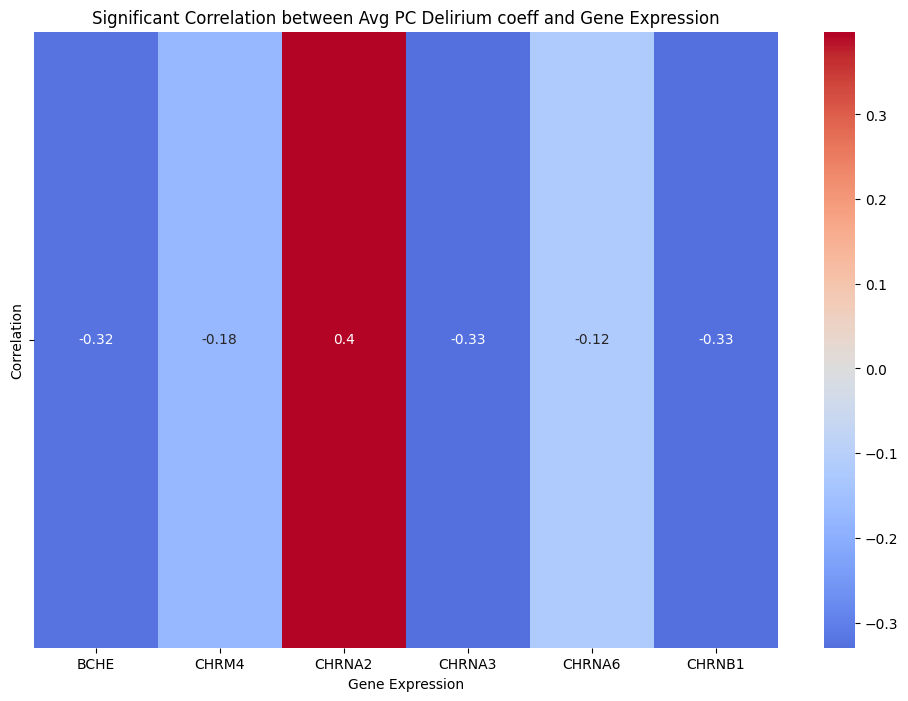

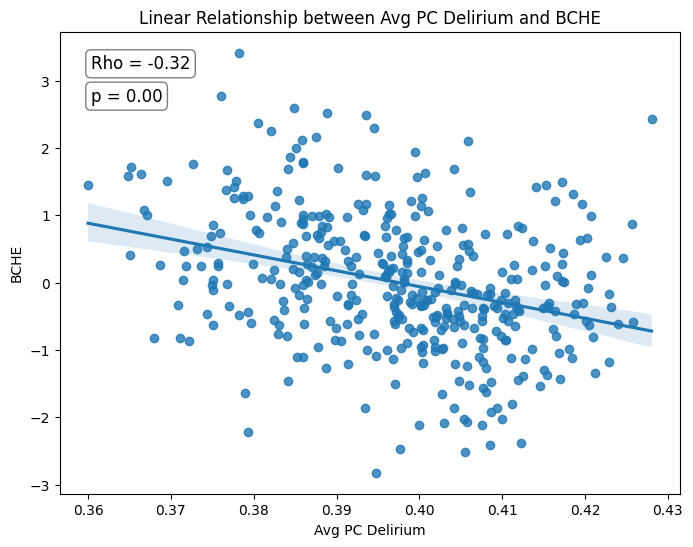

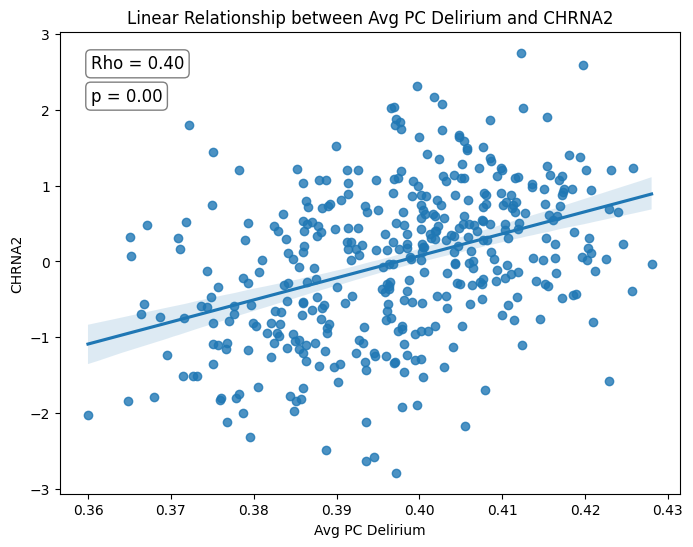

In [14]:
# Ensure significant_results contains numeric data for plotting
name_suffix = 'Avg PC Delirium'
if 'Correlation' in significant_results.columns:
    correlation_values = significant_results[['Correlation']].astype(float)
else:
    raise ValueError("significant_results does not contain a 'Correlation' column.")

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_values.T, annot=True, cmap='coolwarm', center=0, xticklabels=significant_results['Gene'])
plt.title(f'Significant Correlation between {name_suffix} coeff and Gene Expression')
plt.xlabel('Gene Expression')  # Add x-axis label
plt.show()

# Iterate over significant receptors
for gene in significant_results.Gene:  # Use the gene names from significant_results
    plt.figure(figsize=(8, 6))
    sns.regplot(x=analyse_data.flatten(), y=ach_gene_data[gene])
    plt.xlabel(f'{name_suffix}')
    plt.ylabel(gene)
    plt.title(f'Linear Relationship between {name_suffix} and {gene}')
    
    # Calculate correlation
    rho = significant_results[significant_results['Gene'] == gene]['Correlation'].values[0]
    pval = significant_results[significant_results['Gene'] == gene]['P-Value Permuted'].values[0]
    
    plt.text(0.05, 0.95, f'Rho = {rho:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.text(0.05, 0.88, f'p = {pval:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.show()

In [15]:
name_suffix ='Avg PC'
# Calculate the correlation between avg_pc_del and receptor_data
[correlations_del,pvalue_del]=stats.permtest_pearsonr(mean_pc_del,ach_gene_data, n_perm=1000)

# Calculate the correlation between avg nondel LC FC and receptor_data
[correlations_nondel,pvalue_nondel]=stats.permtest_pearsonr(mean_pc_nondel,ach_gene_data, n_perm=1000)

# Create DataFrames for easier plotting
# Create DataFrames for easier plotting
correlation_df_del_pc = pd.DataFrame({
    'Gene': ach_gene_data.columns,
    'Correlation': correlations_del,
    'P-Value Permuted': pvalue_del
})

correlation_df_nondel_pc = pd.DataFrame({
    'Gene': ach_gene_data.columns,
    'Correlation': correlations_nondel,
    'P-Value Permuted': pvalue_nondel
})

# Define the significance threshold
significance_threshold = 0.05

# Filter the DataFrame for significant results
significant_results_del = correlation_df_del_pc[correlation_df_del_pc['P-Value Permuted'] < significance_threshold]
significant_results_nondel = correlation_df_nondel_pc[correlation_df_nondel_pc['P-Value Permuted'] < significance_threshold]
# Plot the correlation matrices side by side
# Create dynamic titles
title_del = f'Correlation between Avg. {name_suffix} Delirium and Gene Expression'
title_nondel = f'Correlation between Avg. {name_suffix} Non-Del and Gene Expression'

# Ensure significant_results_del and significant_results_nondel contain numeric data for plotting
if 'Correlation' in significant_results_del.columns and 'Correlation' in significant_results_nondel.columns:
    correlation_values_del = significant_results_del[['Correlation']].astype(float).T  # Transpose for heatmap
    correlation_values_nondel = significant_results_nondel[['Correlation']].astype(float).T  # Transpose for heatmap
else:
    raise ValueError("One of the significant_results DataFrames does not contain a 'Correlation' column.")

# Create subplots for side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for significant_results_del
sns.heatmap(correlation_values_del, annot=True, cmap='coolwarm', center=0,
            xticklabels=significant_results_del['Gene'].values, ax=axes[0])
axes[0].set_title(title_del)
axes[0].set_xlabel('Gene Names')


# Heatmap for significant_results_nondel
sns.heatmap(correlation_values_nondel, annot=True, cmap='coolwarm', center=0,
            xticklabels=significant_results_nondel['Gene'].values, ax=axes[1])
axes[1].set_title(title_nondel)
axes[1].set_xlabel('Gene Names')


plt.tight_layout()
plt.show()


## Cholinergic relevant receptors functions
- BCHE – Butyrylcholinesterase
Function: An enzyme that hydrolyzes choline-based esters like acetylcholine (ACh), similar to acetylcholinesterase (ACHE), but with broader substrate specificity.

Role in Brain: Acts as a backup or modulator of ACh breakdown. Expressed in neurons and glia, with increased roles in aging and neurodegeneration (e.g., Alzheimer's disease).

Expression: Widespread but varies across regions; notable in cortex, hippocampus, and subcortical areas.

- CHRM4 – Cholinergic Receptor Muscarinic 4
Function: G-protein-coupled muscarinic receptor (M4 subtype) involved in inhibitory signaling via Gi/o proteins.

Role in Brain: Modulates dopamine release, particularly in the striatum and cortex; implicated in cognitive processes and psychiatric disorders (e.g., schizophrenia).

Expression: High in striatum (caudate, putamen) and prefrontal cortex.

- CHRNA2 – Cholinergic Receptor Nicotinic Alpha 2 Subunit
Function: A component of nicotinic acetylcholine receptors (nAChRs), forming pentameric ligand-gated ion channels.

Role in Brain: Less common than other subunits; thought to play roles in hippocampal function, attention, and arousal.

Expression: Moderate expression, especially in hippocampus and cortex.

- CHRNA3 – Cholinergic Receptor Nicotinic Alpha 3 Subunit
Function: Another subunit of nAChRs, typically forming heteromeric receptors with beta subunits like CHRNB4.

Role in Brain: Involved in autonomic and sensory processing; present in subcortical structures and brainstem.

Expression: High in medulla, thalamus, and autonomic ganglia.

- CHRNA6 – Cholinergic Receptor Nicotinic Alpha 6 Subunit
Function: Nicotinic receptor subunit important in dopaminergic signaling.

Role in Brain: Highly expressed in dopaminergic areas like the substantia nigra and ventral tegmental area (VTA); involved in reward and motor control.

Expression: Very specific to midbrain dopaminergic nuclei.

- CHRNB1 – Cholinergic Receptor Nicotinic Beta 1 Subunit
Function: A beta subunit forming part of nicotinic receptors, typically more prominent in muscle-type receptors, but also expressed in some brain areas.

Role in Brain: Less well understood in the brain; may be involved in neuromuscular signaling and some central functions.

Expression: Lower in the CNS; some expression noted in brainstem and motor areas.



FileNotFoundError: [Errno 2] No such file or directory: '/Users/ntaylor/Desktop/AAS_manuscript/Data_analysis/Gene_related_expression/BCHE_avg_pc_grouped.svg'

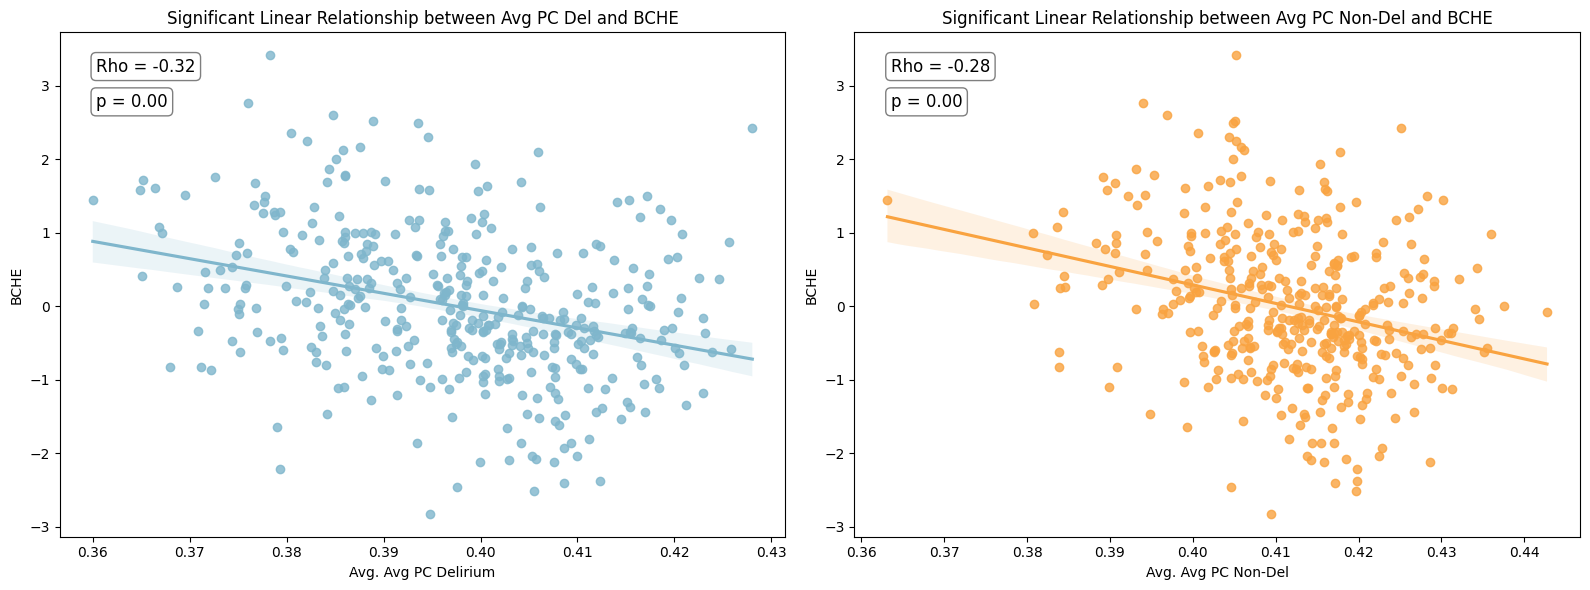

In [ ]:
# Plot the linear relationships side by side for each receptor
#colours <- c(`Non-Delirious` = "#f9a340", Delirious = "#7fb6cc")
for gene in significant_results_nondel['Gene']:
    #i = np.where(gene_names == receptor)[0][0]  # Find the corresponding index in receptor_names
    
    # Check if receptor exists in significant_results_del
    if gene not in significant_results_del['Gene'].values:
        print(f"Skipping receptor {gene} for Avg. PC Del as it is not significant.")
        continue
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot for Avg. PC Del
    sns.regplot(x=mean_pc_del.flatten(), y=ach_gene_data[gene], ax=axes[0], scatter_kws={'color': '#7fb6cc'}, line_kws={'color': '#7fb6cc'})
    axes[0].set_xlabel(f'Avg. {name_suffix} Delirium')
    axes[0].set_ylabel(gene)
    axes[0].set_title(f'Significant Linear Relationship between {name_suffix} Del and {gene}')
    # Calculate correlation for Avg. PC Del
    rho_del = significant_results_del[significant_results_del['Gene'] == gene]['Correlation'].values[0]
    pval_del = significant_results_del[significant_results_del['Gene'] == gene]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Del
    axes[0].text(0.05, 0.95, f'Rho = {rho_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[0].text(0.05, 0.88, f'p = {pval_del:.2f}', transform=axes[0].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Plot for Avg. PC Non-Del
    sns.regplot(
        x=mean_pc_nondel.flatten(),
        y=ach_gene_data[gene],
        ax=axes[1],
        scatter_kws={'color': '#f9a340'},
        line_kws={'color': '#f9a340'},
        ci=95
    )
    axes[1].set_xlabel(f'Avg. {name_suffix} Non-Del')
    axes[1].set_ylabel(gene)
    axes[1].set_title(f'Significant Linear Relationship between {name_suffix} Non-Del and {gene}')
    
    # Calculate correlation for Avg. PC Non-Del
    rho_nondel = significant_results_nondel[significant_results_nondel['Gene'] == gene]['Correlation'].values[0]
    pval_nondel = significant_results_nondel[significant_results_nondel['Gene'] == gene]['P-Value Permuted'].values[0]
    
    # Add correlation and p-value text for Avg. PC Non-Del
    axes[1].text(0.05, 0.95, f'Rho = {rho_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    axes[1].text(0.05, 0.88, f'p = {pval_nondel:.2f}', transform=axes[1].transAxes, 
                 fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    # Save the figure as SVG in the desired directory
    #plt.savefig(f'/Users/ntaylor/Desktop/AAS_manuscript/Data_analysis/Gene_related_expression/{gene}_avg_pc_grouped.svg', format='svg',bbox_inches='tight')
    plt.show()